# Benchmarking models at locating spatial expression of cell types with scRNA-seq reference and Visium spatial (mouse brain)

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

#import cell2location.models as c2l
#import cell2location.plt as c2lpl
#import cell2location.cluster_averages 
import cell2location
import pymc3 as pm

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
import itertools

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### The purpose of the notebook is to benchmark several versions of the model using mouse brain data.

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/'

## Read datasets and train cell2location

In [3]:
adata = anndata.read(f'{sp_data_folder}synth_adata_real_mg_20210131.h5ad')
adata.uns['spatial'] = {'x': 'y'}

adata_snrna_raw = anndata.read(f'{sp_data_folder}training_5705STDY8058280_5705STDY8058281_20210131.h5ad')

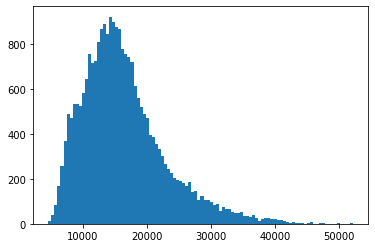

In [4]:
plt.hist(np.array(adata.X.sum(1)).flatten(), bins=100);

In [5]:
sc.pp.calculate_qc_metrics(adata, inplace=True) 

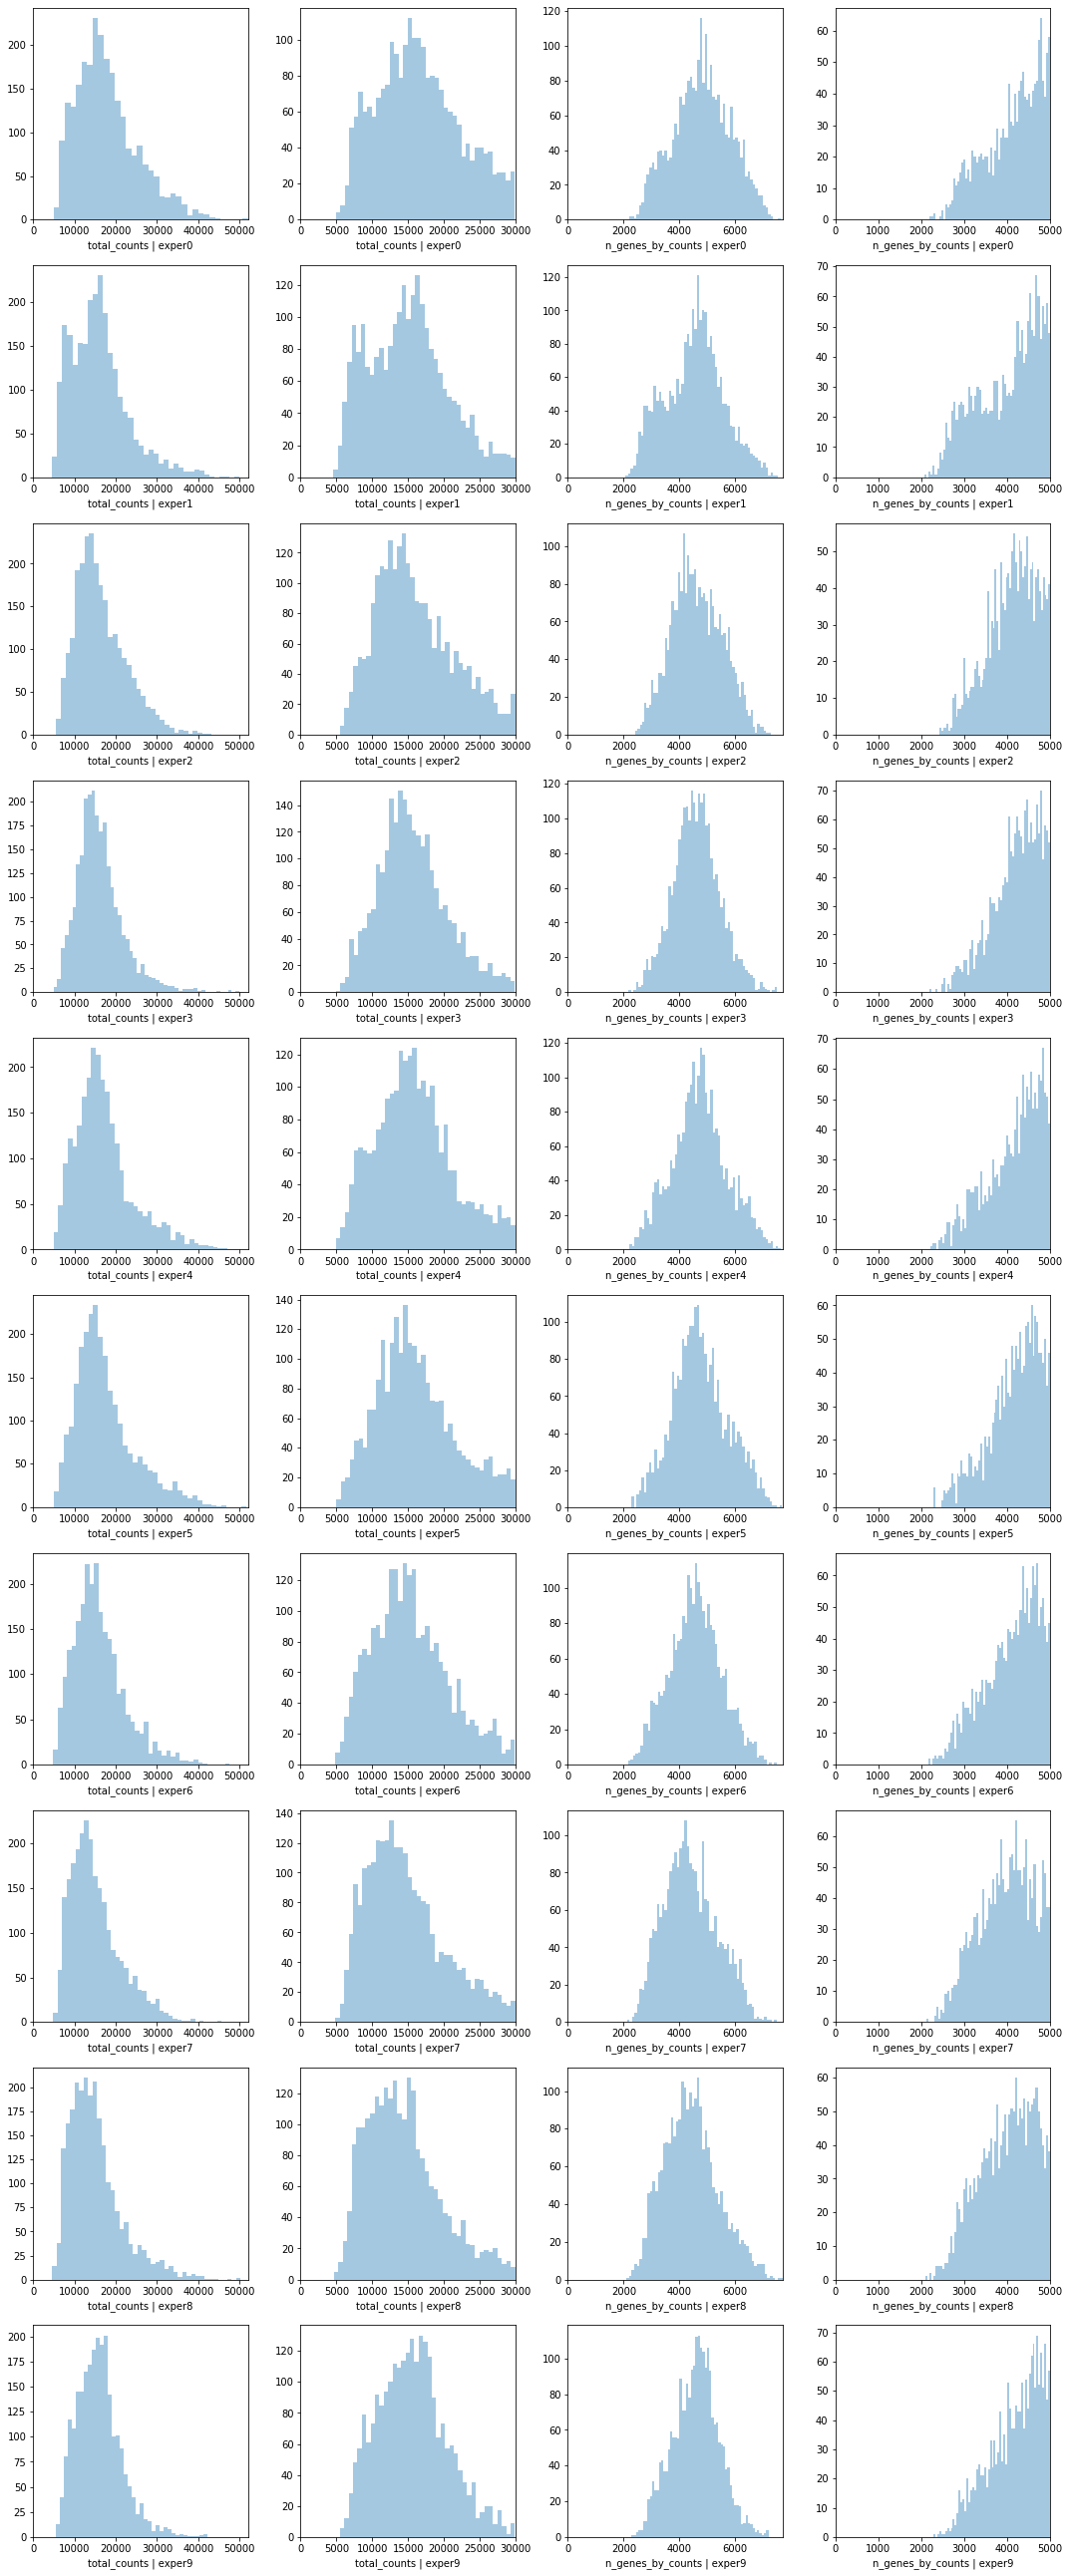

In [6]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(adata.obs['sample'].unique()), 4, figsize=(15, 4*len(adata.obs['sample'].unique())-4))
#axs = axs.reshape((len(adata.obs['sample'].unique()), 4))
for i, s in enumerate(adata.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')

    #slide = select_slide(adata, s)
    slide = adata[adata.obs['sample'] == s]
    sns.distplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<30000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 30000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<5000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 5000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

In [7]:
import scipy
adata_snrna_raw.X = scipy.sparse.csr_matrix(adata_snrna_raw.X)

In [8]:
import scipy
adata.X = scipy.sparse.csr_matrix(adata.X)

Select genes using expression in non-zero cells

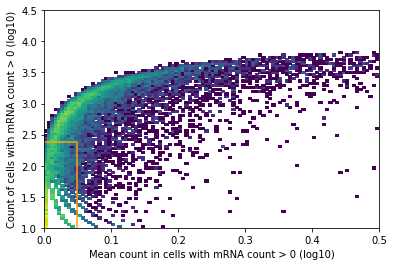

In [9]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = (adata_snrna_raw.X.toarray() > 0).sum(0)
adata_snrna_raw.var['nonz_mean'] = adata_snrna_raw.X.toarray().sum(0) / adata_snrna_raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.var['n_cells']), bins=100,
           norm=matplotlib.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);

nonz_mean_cutoff = np.log10(1.12) # cut off for expression in non-zero cells
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.0005) # cut off percentage for cells with higher expression
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)# cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color = 'orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color = 'orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color = 'orange');
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)');
plt.ylabel('Count of cells with mRNA count > 0 (log10)');

In [10]:
adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)].shape

(8111, 12422)

In [11]:
# select genes based on mean expression in non-zero cells
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)]

In [12]:
adata_snrna_raw

View of AnnData object with n_obs × n_vars = 8111 × 12422
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', 'annotation_1', 'n_genes'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells', 'nonz_mean'

Add counts matrix as `adata.raw` 

In [13]:
adata_snrna_raw.raw = adata_snrna_raw

In [14]:
adata_vis = adata.copy()
adata_vis.raw = adata_vis

In [15]:
adata_vis.var_names

Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000033845',
       'ENSMUSG00000033813', 'ENSMUSG00000002459', 'ENSMUSG00000033793',
       'ENSMUSG00000025905', 'ENSMUSG00000025907', 'ENSMUSG00000090031',
       'ENSMUSG00000033740',
       ...
       'ENSMUSG00000024993', 'ENSMUSG00000063698', 'ENSMUSG00000024997',
       'ENSMUSG00000003228', 'ENSMUSG00000074733', 'ENSMUSG00000059326',
       'ENSMUSG00000051412', 'ENSMUSG00000079834', 'ENSMUSG00000095041',
       'ENSMUSG00000063897'],
      dtype='object', name='ENSEMBL', length=12809)

In [16]:
adata_vis.var

gene_level  n_cells_by_counts  mean_counts  \
ENSEMBL                                                          
ENSMUSG00000051951    0.003928               4909      0.22492   
ENSMUSG00000089699    0.000026                  5      0.00020   
ENSMUSG00000033845    0.697608              13989      1.10868   
ENSMUSG00000033813    0.430858              11230      0.71892   
ENSMUSG00000002459    0.070863              14567      0.95816   
...                        ...                ...          ...   
ENSMUSG00000059326    0.064865               5380      0.25412   
ENSMUSG00000051412    0.801130               9856      0.66184   
ENSMUSG00000079834    0.008582                584      0.02376   
ENSMUSG00000095041    0.081611              16564      1.26312   
ENSMUSG00000063897    0.263697               4163      0.20068   

                    log1p_mean_counts  pct_dropout_by_counts  total_counts  \
ENSEMBL                                                                      
ENSMUSG00000051951           0.202876                 80.364          5623   
ENSMUSG00000089699           0.000200                 99.980             5   
ENSMUSG00000033845           0.746062                 44.044         27717   
ENSMUSG00000033813           0.541696                 55.080         17973   
ENSMUSG00000002459           0.672005                 41.732         23954   
...                               ...                    ...           ...   
ENSMUSG00000059326           0.226434                 78.480          6353   
ENSMUSG00000051412           0.507925                 60.576         16546   
ENSMUSG00000079834           0.023482                 97.664           594   
ENSMUSG00000095041           0.816744                 33.744         31578   
ENSMUSG00000063897           0.182888                 83.348          5017   

                    log1p_total_counts  
ENSEMBL                                 
ENSMUSG00000051951            8.634798  
ENSMUSG00000089699            1.791759  
ENSMUSG00000033845           10.229837  
ENSMUSG00000033813            9.796682  
ENSMUSG00000002459           10.083932  
...                                ...  
ENSMUSG00000059326            8.756840  
ENSMUSG00000051412            9.713960  
ENSMUSG00000079834            6.388561  
ENSMUSG00000095041           10.360248  
ENSMUSG00000063897            8.520787  

[12809 rows x 7 columns]

In [17]:
from re import sub
adata_snrna_raw.obs['sample'] = [sub('_.+$','', i) for i in adata_snrna_raw.obs.index]

### First, infer average expression in each cell type

In [18]:
adata_snrna_raw

AnnData object with n_obs × n_vars = 8111 × 12422
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', 'annotation_1', 'n_genes'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells', 'nonz_mean'

```python
from cell2location import run_regression
r, adata_snrna_raw = run_regression(adata_snrna_raw, 
                                    
                   verbose=True, return_all=True,
                                 
                   train_args={
                    'covariate_col_names': ['annotation_1'], 
                    'sample_name_col': 'sample',
                    'tech_id': None,
                    'stratify_cv': 'annotation_1',
                       
                    'n_epochs': 100, 'minibatch_size': 1024, 'learning_rate': 0.01,
                       
                    'use_average_as_initial_value': True, 'use_cuda': True,
                       
                    'train_proportion': 0.9,
                    'l2_weight': {'l2_weight': 0.001, 'sample_scaling_weight': 0.5,
                           'gene_overdisp_weight': 0.1},  # True = use defaults for the model
                    
                    'readable_var_name_col': 'SYMBOL', 'use_raw': True},
                                 
                   model_kwargs={},
                   posterior_args={},
                                 
                   export_args={'path': results_folder + 'regression_model/', 'save_model': True,
                                'run_name_suffix': 'with_tissue_zones'})

reg_mod = r['mod']
#adata_snrna_raw = r['sc_data']
```

In [19]:
reg_mod_name = 'RegressionGeneBackgroundCoverageTorch_51covariates_8111cells_12422geneswith_tissue_zones'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
#r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
#reg_mod = r['mod']
#r_reg = pickle.load(file = open(f'{reg_path}model_settings.p', "rb"))
#r_reg

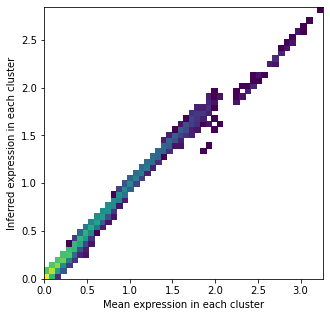

In [20]:
# export inferred averages in each cluster
inf_aver = pd.DataFrame(#adata_snrna_raw.uns['regression_mod']['post_sample_q05']['gene_factors'].T,
                        adata_snrna_raw.uns['regression_mod']['post_sample_means']['gene_factors'].T,
             index=adata_snrna_raw.uns['regression_mod']['var_names'], 
             columns=adata_snrna_raw.uns['regression_mod']['fact_names'])
inf_aver = inf_aver.loc[:, np.array(['annotation_1_' in i for i in inf_aver.columns])]
from re import sub
inf_aver.columns = [sub('annotation_1_', '', i) for i in inf_aver.columns]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, 'annotation_1')
aver = aver.loc[adata_snrna_raw.var_names, inf_aver.columns]

# export inferred averages in each cluster
#inf_aver = reg_mod.covariate_effects.copy()
#from re import sub
#inf_aver.columns = [sub('mean_cov_effect_Subset_', '', i) for i in inf_aver.columns]
#inf_aver = inf_aver.loc[aver.index, aver.columns]

rcParams['figure.figsize'] = 5, 5
plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
           bins=50, norm=matplotlib.colors.LogNorm());
plt.xlabel('Mean expression in each cluster');
plt.ylabel('Inferred expression in each cluster');

In [21]:
inf_aver

Astro_AMY  Astro_AMY_CTX     Astro_CTX     Astro_HPC  \
ENSMUSG00000051951   0.012509       0.030425  1.005507e-02  5.359366e-02   
ENSMUSG00000089699   0.006211       0.004515  7.332511e-09  7.822795e-09   
ENSMUSG00000033845   0.108923       0.033173  3.914691e-02  3.407474e-02   
ENSMUSG00000033813   0.048582       0.104406  1.285341e-01  7.109736e-02   
ENSMUSG00000002459   2.664850       3.067285  3.271224e+00  3.492710e+00   
...                       ...            ...           ...           ...   
ENSMUSG00000064370   0.121929       0.101013  1.662863e-01  1.399361e-01   
ENSMUSG00000051412   0.080739       0.060860  5.444401e-02  1.768604e-02   
ENSMUSG00000079834   0.209774       0.123219  1.727202e-01  9.581321e-02   
ENSMUSG00000095041   0.122693       0.221602  2.658242e-01  1.983381e-01   
ENSMUSG00000063897   0.047135       0.020894  2.013705e-02  3.732218e-02   

                    Astro_HYPO  Astro_THAL_lat  Astro_THAL_med      Astro_WM  \
ENSMUSG00000051951    0.008253        0.064003        0.045352  1.762414e-02   
ENSMUSG00000089699    0.009702        0.015000        0.012339  2.187605e-02   
ENSMUSG00000033845    0.063219        0.099592        0.079603  7.772008e-02   
ENSMUSG00000033813    0.039291        0.026488        0.059248  7.517914e-02   
ENSMUSG00000002459    1.250632        1.269952        1.057511  3.244063e+00   
...                        ...             ...             ...           ...   
ENSMUSG00000064370    0.080974        0.061845        0.046601  6.084076e-01   
ENSMUSG00000051412    0.019386        0.030146        0.037793  8.481868e-09   
ENSMUSG00000079834    0.153563        0.193688        0.214270  8.494480e-09   
ENSMUSG00000095041    0.203783        0.222463        0.106993  5.503593e-02   
ENSMUSG00000063897    0.019632        0.014015        0.052788  3.897170e-02   

                    Ext_Amy_1  Ext_Amy_2  ...   Inh_Vip    LowQ_2  \
ENSMUSG00000051951  15.928912  12.917710  ...  4.795861  4.528843   
ENSMUSG00000089699   3.754444   2.789158  ...  1.031598  1.037042   
ENSMUSG00000033845   0.246512   0.130134  ...  0.059994  0.080287   
ENSMUSG00000033813   0.164718   0.177850  ...  0.163613  0.230734   
ENSMUSG00000002459   0.768309   0.598986  ...  0.266393  0.032791   
...                       ...        ...  ...       ...       ...   
ENSMUSG00000064370   0.317106   0.331083  ...  0.171908  0.192032   
ENSMUSG00000051412   0.113388   0.112030  ...  0.045511  0.014056   
ENSMUSG00000079834   0.421241   0.401686  ...  0.247192  0.148152   
ENSMUSG00000095041   1.452682   1.678397  ...  0.882560  1.862407   
ENSMUSG00000063897   0.072504   0.065473  ...  0.087889  0.054046   

                           Micro      Nb_1          Nb_2     OPC_1     OPC_2  \
ENSMUSG00000051951  2.080448e-02  1.473291  2.662451e-01  1.672836  0.397386   
ENSMUSG00000089699  6.948521e-09  0.430513  4.540244e-02  0.342018  0.058468   
ENSMUSG00000033845  3.278148e-02  0.089115  2.891131e-02  0.050014  0.046113   
ENSMUSG00000033813  8.710550e-02  0.116066  6.265426e-02  0.129172  0.072901   
ENSMUSG00000002459  9.052837e-03  0.032243  2.383682e-01  0.485955  0.054811   
...                          ...       ...           ...       ...       ...   
ENSMUSG00000064370  4.760990e-02  0.109529  9.318745e-02  0.081206  0.180818   
ENSMUSG00000051412  1.982695e-02  0.100616  7.969802e-09  0.054375  0.073011   
ENSMUSG00000079834  5.136155e-02  0.087012  2.566674e-02  0.105467  0.226450   
ENSMUSG00000095041  1.032898e+00  1.421899  3.114445e-01  0.357791  0.545915   
ENSMUSG00000063897  2.414099e-02  0.036461  3.184866e-02  0.066473  0.065561   

                     Oligo_1   Oligo_2     Unk_1  
ENSMUSG00000051951  1.551169  0.560366  1.006497  
ENSMUSG00000089699  0.584137  0.142750  0.188549  
ENSMUSG00000033845  0.028590  0.039603  0.050697  
ENSMUSG00000033813  0.050134  0.053157  0.015894  
ENSMUSG00000002459  0.021572  0.007194  0.035584  
...                      ...       ...       ...  

In [22]:
from cell2location.cluster_averages.cluster_averages import get_cluster_averages
from cell2location.cluster_averages.cluster_averages import get_cluster_variances
eps = 1e-8
aver = get_cluster_averages(adata_snrna_raw, 'annotation_1') + eps
variances = get_cluster_variances(adata_snrna_raw, 'annotation_1') + eps

shape = aver ** 2 / variances

## Model training

`pycell2location.run_cell2location` is a wrapper for cell2location model workflow:
We summarise single cell data, train the model, sample prior and posterior, save and export results, including diagnostic plots.

`pycell2location.run_cell2location` takes single cell and spatial anndata as input together with a bunch of parameters.

In [23]:
results_folder

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/'

In [24]:
adata_vis.obs['sample']

exper0_location_0       exper0
exper0_location_1       exper0
exper0_location_2       exper0
exper0_location_3       exper0
exper0_location_4       exper0
                         ...  
exper9_location_2495    exper9
exper9_location_2496    exper9
exper9_location_2497    exper9
exper9_location_2498    exper9
exper9_location_2499    exper9
Name: sample, Length: 25000, dtype: category
Categories (10, object): ['exper0', 'exper1', 'exper2', 'exper3', ..., 'exper6', 'exper7', 'exper8', 'exper9']

In [25]:
from cell2location.models.LocationModelLinearDependentWMultiExperiment import LocationModelLinearDependentWMultiExperiment
models_list = [LocationModelLinearDependentWMultiExperiment]
from cell2location.models.LocationModelLinearDependentWMultiExperimentNoMg import LocationModelLinearDependentWMultiExperimentNoMg
models_list = models_list + [LocationModelLinearDependentWMultiExperimentNoMg]
from cell2location.models.LocationModelHierarchicalWMultiExperiment import LocationModelHierarchicalWMultiExperiment
models_list = models_list + [LocationModelHierarchicalWMultiExperiment]
from cell2location.models.LocationModelMultiExperiment import LocationModelMultiExperiment
models_list = models_list + [LocationModelMultiExperiment]
from cell2location.models.LocationModelLinearDependentWMultiExperimentNoSegLs import LocationModelLinearDependentWMultiExperimentNoSegLs
models_list = models_list + [LocationModelLinearDependentWMultiExperimentNoSegLs]
from pycell2location.models.LocationModelLinearDependentWMultiExperimentLocationBackgroundNormGeneAlpha import LocationModelLinearDependentWMultiExperimentLocationBackgroundNormGeneAlpha
models_list = models_list + [LocationModelLinearDependentWMultiExperimentLocationBackgroundNormGeneAlpha]

In [26]:
rcParams['figure.figsize'] = 5, 5
for m in models_list:
    
    r = cell2location.run_cell2location(
                          sc_data=inf_aver,
                          sp_data=adata_vis[adata_vis.obs['sample'] == 'exper0',:],
        
                          model_name=m,
        
                          verbose=True, return_all=True,

                          summ_sc_data_args={
                              'cluster_col': "annotation_1",
                              # select marker genes of cell types by specificity of their expression signatures
                              'selection': "cluster_specificity", 
                              # specificity cutoff (1 = max, 0 = min)
                              'selection_specificity': 0.06
                          },

                          train_args={'n_iter': 30000, 'learning_rate': 0.005,
                                      'total_grad_norm_constraint': 200,
                                      'sample_prior': False, 'n_prior_samples': 20,
                                      'readable_var_name_col': None,
                                      'sample_name_col': 'sample'},

                          posterior_args={'n_samples': 1000},
                          export_args={'path': results_folder,
                                       'save_model': False, 
                                       'run_name_suffix': '_defaults_ceps9_cps4_fps5_inf_shape01_gl2',
                                       'scanpy_coords_name': 'X_spatial'},
                          model_kwargs={
                                        'cell_number_prior': {'cells_per_spot': 9, 'factors_per_spot': 5, 
                                                              'combs_per_spot': 4
                                                             }
                          }
    )

### Summarising single cell clusters ###
### Creating model ### - time 0.01 min
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_6565genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2
### Training model ###


Finished [100%]: Average Loss = 1.4083e+07


Finished [100%]: Average Loss = 1.4083e+07



### Sampling posterior ### - time 15.52 min



### Saving results ###
### Ploting results ###
### Plotting posterior of W / cell locations ###
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Done ### - time 16.75 min
### Summarising single cell clusters ###
### Creating model ### - time 0.01 min
### Analysis name: LocationModelLinearDependentWMultiExperimentNoMg_1experiments_49clusters_2500locations_6565genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2
### Training model ###


Finished [100%]: Average Loss = 1.4674e+07


Finished [100%]: Average Loss = 1.4674e+07



### Sampling posterior ### - time 13.29 min



### Saving results ###
### Ploting results ###
### Plotting posterior of W / cell locations ###
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Done ### - time 14.53 min
### Summarising single cell clusters ###
### Creating model ### - time 0.01 min
### Analysis name: LocationModelHierarchicalWMultiExperiment_1experiments_49clusters_2500locations_6565genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2
### Training model ###


Finished [100%]: Average Loss = 1.4073e+07


Finished [100%]: Average Loss = 1.4073e+07



### Sampling posterior ### - time 14.01 min



### Saving results ###
### Ploting results ###
### Plotting posterior of W / cell locations ###
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Done ### - time 14.95 min
### Summarising single cell clusters ###
### Creating model ### - time 0.01 min
### Analysis name: LocationModelMultiExperiment_1experiments_49clusters_2500locations_6565genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2
### Training model ###


Finished [100%]: Average Loss = 1.405e+07


Finished [100%]: Average Loss = 1.405e+07



### Sampling posterior ### - time 14.12 min



### Saving results ###
### Ploting results ###
### Plotting posterior of W / cell locations ###
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Done ### - time 15.08 min
### Summarising single cell clusters ###
### Creating model ### - time 0.01 min
### Analysis name: LocationModelLinearDependentWMultiExperimentNoSegLs_1experiments_49clusters_2500locations_6565genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2
### Training model ###


Finished [100%]: Average Loss = 1.4089e+07


Finished [100%]: Average Loss = 1.4089e+07



### Sampling posterior ### - time 12.66 min



### Saving results ###
### Ploting results ###
### Plotting posterior of W / cell locations ###
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Done ### - time 13.78 min
### Summarising single cell clusters ###
### Creating model ### - time 0.01 min
### Analysis name: LocationModelLinearDependentWMultiExperimentLocationBackgroundNormGeneAlpha_1experiments_49clusters_2500locations_6565genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2
### Training model ###


Finished [100%]: Average Loss = 1.4077e+07


Finished [100%]: Average Loss = 1.4077e+07



### Sampling posterior ### - time 16.65 min



### Saving results ###
### Ploting results ###
### Plotting posterior of W / cell locations ###
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Done ### - time 17.85 min


## Evaluate inferred cell density (`spot_factors`) and mRNA count (`nUMI_factors`)

In [25]:
r_load = {'run_name': 'LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_6565genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2'}
#r_load = {'run_name': 'LocationModel_1experiments_46clusters_2000locations_12281genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2'}

fig_path=results_folder +r_load['run_name']+'/plots'

sp_data_file = results_folder +r_load['run_name']+'/sp.h5ad'
adata_vis_res = anndata.read(sp_data_file)

In [26]:
file = results_folder + r_load['run_name']+'/model_.p'
r = pickle.load(file = open(file, "rb"))

In [27]:
# look at NBoverdispersion hyperprior
adata_vis_res.uns['mod']['post_sample_means']['phi_hyp']

array([[1.3850497]], dtype=float32)

In [28]:
fig_path

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_6565genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2/plots'

In [29]:
from re import sub
cell_count = adata_vis_res.obs.loc[:, ['cell_abundances_' in i for i in adata_vis_res.obs.columns]]
cell_count.columns =  [sub('cell_abundances_', '', i) for i in cell_count.columns]
cell_count_columns = cell_count.columns
umi_count = adata_vis_res.obs.loc[:, ['UMI_count_' in i for i in adata_vis_res.obs.columns]]
umi_count.columns =  [sub('UMI_count_', '', i) for i in umi_count.columns]

spot_factors = adata_vis_res.obs[['mean_spot_factors' + i for i in cell_count_columns]]
spot_factors.columns =  [sub('mean_spot_factors', '', i) for i in spot_factors.columns]

spot_factors_sd = adata_vis_res.obs[['sd_spot_factors' + i for i in cell_count_columns]]
spot_factors_sd.columns =  [sub('sd_spot_factors', '', i) for i in spot_factors_sd.columns]

infer_cell_count = spot_factors[cell_count.columns]
#infer_cell_count = cells_per_factor[cell_count.columns]

nUMI_factors = adata_vis_res.obs[['mean_nUMI_factors' + i for i in cell_count_columns]]
nUMI_factors.columns =  [sub('mean_nUMI_factors', '', i) for i in nUMI_factors.columns]

In [30]:
#spot_factors = spot_factors / spot_factors_sd

infer_cell_count = spot_factors[cell_count.columns]
infer_nUMI_count = nUMI_factors[cell_count.columns]

In [31]:
# mean number of cell types per location
(cell_count.values > 1).sum(1).mean(), (cell_count.values).sum(1).mean(),\
 (infer_cell_count.values > 1).sum(1).mean(), (infer_cell_count.values).sum(1).mean()

(3.4432, 12.446070097879135, 3.2848, 16.824746413374925)

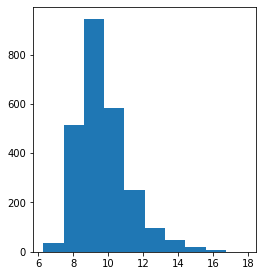

In [32]:
rcParams['figure.figsize'] = 4, 4.5
# look at the numberof cells per spot factors
plt.hist(adata_vis_res.uns['mod']['post_sample_means']['cells_per_spot']);

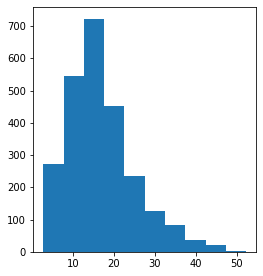

In [33]:
# look at the numberof expressed factors
plt.hist(spot_factors.sum(1));

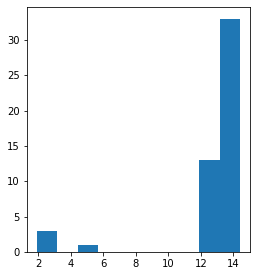

In [34]:
# look at the number of expressed factors
plt.hist(adata_vis_res.uns['mod']['post_sample_means']['factors_per_combs']);

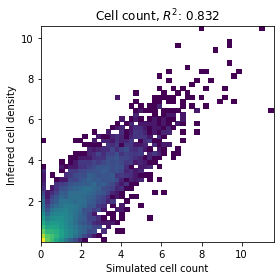

In [35]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_count.values.flatten(), 
           infer_cell_count.values.flatten(),# / np.mean(adata_vis_res.var['gene_level'].values),
           bins=[50, 50], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell count');
plt.ylabel('Inferred cell density');
plt.title(r'Cell count, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_cell_count.values.flatten()), 3)[0,1]));
#plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig(fig_path + '/Cell_density_cor.pdf')

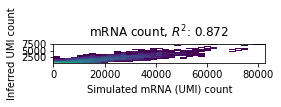

In [36]:
rcParams['figure.figsize'] = 4, 4.5
rcParams["axes.facecolor"] = "white"

plt.hist2d(umi_count.values.flatten(), 
           nUMI_factors.values.flatten() \
           / np.mean(adata_vis_res.var['gene_level'].values),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated mRNA (UMI) count');
plt.ylabel('Inferred UMI count');
plt.title('mRNA count, $R^2$: ' \
          + str(np.round(np.corrcoef(umi_count.values.flatten(), 
           nUMI_factors.values.flatten()), 3)[0,1]));
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig(fig_path + '/nUMI_count_cor.pdf')

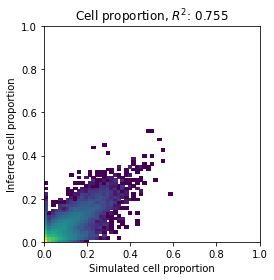

In [37]:
cell_proportions = (cell_count.T / cell_count.sum(1)).T
cell_proportions.iloc[np.isnan(cell_proportions.values)] = 0
infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T

rcParams['figure.figsize'] = 4, 4
plt.hist2d(cell_proportions.values.flatten(), 
           infer_cell_proportions.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell proportion');
plt.ylabel('Inferred cell proportion');
plt.title('Cell proportion, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_proportions.values.flatten(), 
           infer_cell_proportions.values.flatten()), 3)[0,1]));
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 1);
plt.ylim(0, 1);
plt.tight_layout()
plt.savefig(fig_path + '/Cell_proportion_cor.pdf')

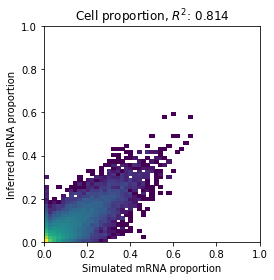

In [38]:
umi_count_proportions = (umi_count.T / umi_count.sum(1)).T
umi_count_proportions.iloc[np.isnan(umi_count_proportions.values)] = 0
infer_nUMI_factors = (nUMI_factors.T / nUMI_factors.sum(1)).T

rcParams['figure.figsize'] = 4, 4
plt.hist2d(umi_count_proportions.values.flatten(), 
           infer_nUMI_factors.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated mRNA proportion');
plt.ylabel('Inferred mRNA proportion');
plt.title('Cell proportion, $R^2$: ' \
          + str(np.round(np.corrcoef(umi_count_proportions.values.flatten(), 
           infer_nUMI_factors.values.flatten()), 3)[0,1]));
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 1);
plt.ylim(0, 1);
plt.tight_layout()
plt.savefig(fig_path + '/mRNA_proportion_cor.pdf')

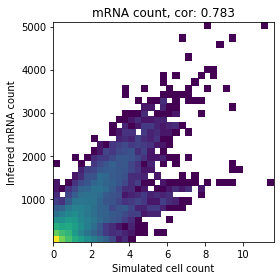

In [39]:
rcParams['figure.figsize'] = 4, 4
plt.hist2d(cell_count.values.flatten(), 
           infer_nUMI_count.values.flatten(),
           bins=35, norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell count');
plt.ylabel('Inferred mRNA count');
plt.title('mRNA count, cor: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_nUMI_count.values.flatten()), 3)[0,1]));
plt.tight_layout();
#plt.savefig(fig_path + '/mRNA_count_cor.pdf')

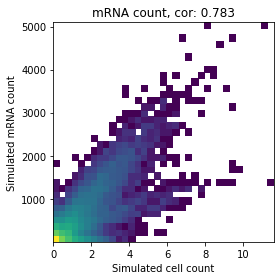

In [40]:
rcParams['figure.figsize'] = 4, 4
plt.hist2d(cell_count.values.flatten(), 
           nUMI_factors.values.flatten(),
           bins=35, norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell count');
plt.ylabel('Simulated mRNA count');
plt.title('mRNA count, cor: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_nUMI_count.values.flatten()), 3)[0,1]));
plt.tight_layout();
#plt.savefig(fig_path + '/mRNA_count_cor.pdf')

In [41]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate

with plt.style.context('seaborn'):
    seaborn_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']


def compute_precision_recall(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = precision_recall_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = average_precision_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = average_precision_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = precision_recall_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def compute_roc(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot ROC curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = roc_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = roc_auc_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = roc_auc_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = roc_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def plot_precision_recall(pos_cell_count, infer_cell_proportions,
                          title='', iso_f1_curves=False,
                          individual_cell_types=True,
                          save=None, mode='macro', curve='PR'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    :param title: plot title
    :param iso_f1_curves: plot iso curves for F1 score?
    :param individual_cell_types: show precision-recall curves for each cell type?
    """
    
    ### calculating ###
    if curve == 'PR':
        precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions, 
                                                                        mode=mode)
        xlabel = 'Recall'
        ylabel = 'Precision'
        
    elif curve == 'ROC':
        recall, precision, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions, 
                                                                        mode=mode)
        xlabel = 'FPR'
        ylabel = 'TPR'
        
    ### plotting ###
    from itertools import cycle
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    lines = []
    labels = []
    
    if iso_f1_curves:
        f_scores = np.linspace(0.2, 0.8, num=4)
        
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

        lines.append(l)
        labels.append('iso-f1 curves')
    
    l, = plt.plot(recall["averaged"], precision["averaged"], color='navy', lw=2)
    lines.append(l)
    labels.append(f'{mode}-average {curve} ({curve} score = {round(average_precision["averaged"], 2)})')

    if individual_cell_types:
        for i, color in zip(infer_cell_proportions.columns, colors):
            l, = plt.plot(recall[i], precision[i], color='gold', lw=1)
            lines.append(l)
        labels.append(f'{curve} for individual cell types')



    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(lines, labels, loc=(0, -.37), prop=dict(size=8))
    
    if save is not None:
        plt.savefig(save)

def compare_precision_recall(pos_cell_count, infer_cell_proportions,
                             method_title, title='',
                             legend_loc=(0, -.37),
                             colors=sc.pl.palettes.default_102,
                             mode='macro', curve='PR'):
    
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells), 
                                        list of inferred parameters for several methods
    :param method_title: title for each infer_cell_proportions
    :param title: plot title
    """
    # setup plot details
    from itertools import cycle
    colors = cycle(colors)
    lines = []
    labels = []
    roc = {}
    
    ### plotting ###
    for i, color in zip(range(len(infer_cell_proportions)), colors):
        
        if curve == 'PR':
            precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'Recall'
            ylabel = 'Precision'
            
            l, = plt.plot(recall["averaged"], precision["averaged"], color=color, lw=3)

        elif curve == 'ROC':
            FPR, TPR, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'FPR'
            ylabel = 'TPR'
            
            l, = plt.plot(FPR["averaged"], TPR["averaged"], color=color, lw=3)
            
        
        lines.append(l)

        labels.append(method_title[i] + '(' + curve + ' score = {0:0.2f})'
                      ''.format(average_precision["averaged"]))
        roc[method_title[i]] = average_precision["averaged"]


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend_loc is not None:
        plt.legend(lines, labels, loc=legend_loc, prop=dict(size=14))

    #plt.show()
    return roc


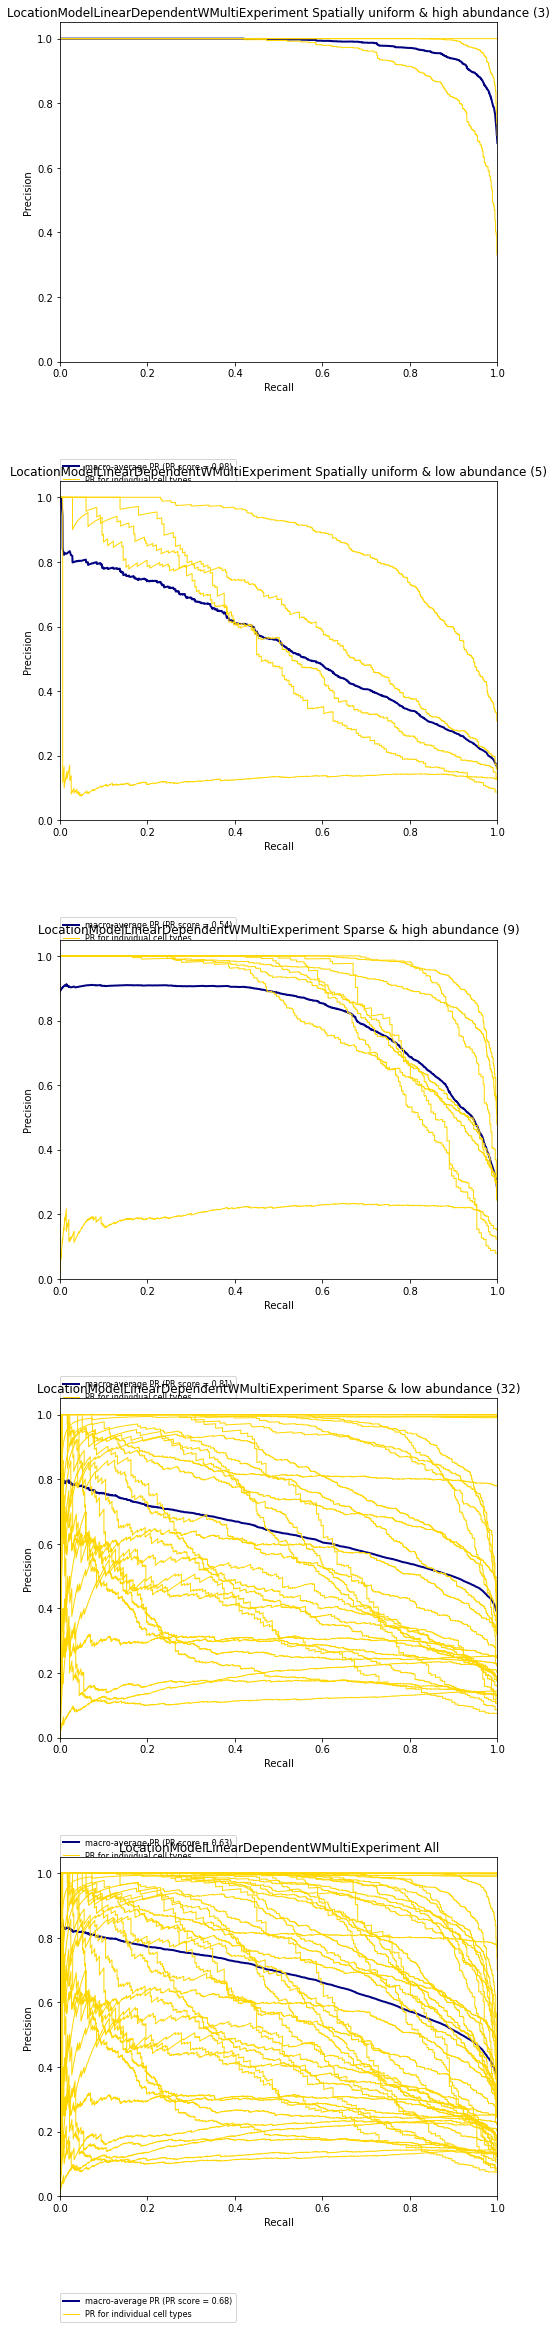

In [42]:
rcParams['figure.figsize'] = 7, 32
rcParams['pdf.fonttype'] = 42
pos_cell_count = cell_count.values > 0.1

def pr_by_category(pos_cell_count, infer_cell_count, design,
                   nrow=5, ncol=1, title='', fig_path=''):

    design_loc = design.loc[cell_count.columns,:]
    
    plt.subplot(nrow, ncol, 1)
    ind = (design_loc['is_uniform'] * design_loc['is_high_density']).values.astype(bool)
    plot_precision_recall(pos_cell_count[:, ind], infer_cell_count.loc[:,ind],
                          title=f'{title} Spatially uniform & high abundance ({ind.sum()})',
                          #save=fig_path + '/Uniform_low_abundance.pdf'
                         )
    
    plt.subplot(nrow, ncol, 2)
    ind = (design_loc['is_uniform'] * (1 - design_loc['is_high_density'])).values.astype(bool)
    plot_precision_recall(pos_cell_count[:, ind], infer_cell_count.loc[:,ind],
                          title=f'{title} Spatially uniform & low abundance ({ind.sum()})',
                          #save=fig_path + '/Uniform_high_abundance.pdf'
                         )
    
    plt.subplot(nrow, ncol, 3)
    ind = ((1 - design_loc['is_uniform']) * design_loc['is_high_density']).values.astype(bool)
    plot_precision_recall(pos_cell_count[:, ind], infer_cell_count.loc[:,ind],
                          title=f'{title} Sparse & high abundance ({ind.sum()})',
                          #save=fig_path + '/Segregated_low_abundance.pdf'
                         )
    
    plt.subplot(nrow, ncol, 4)
    ind = ((1 - design_loc['is_uniform']) * (1 - design_loc['is_high_density'])).values.astype(bool)
    plot_precision_recall(pos_cell_count[:, ind], infer_cell_count.loc[:,ind],
                          title=f'{title} Sparse & low abundance ({ind.sum()})',
                          #save=fig_path + '/Segregated_high_abundance.pdf'
                         )
    
    plt.subplot(nrow, ncol, 5)
    plot_precision_recall(pos_cell_count, infer_cell_count,
                          title=title + ' All',
                          #save=fig_path + '/All.pdf'
                         )
    
from re import sub
model_name = sub('_.+$', '', r['run_name'])
pr_by_category(pos_cell_count, infer_cell_count, adata_vis_res.uns['design']['cell_types2zones'],
               nrow=5, ncol=1, title=model_name,#r['model_name'],#.__name__,
               fig_path=fig_path)
plt.tight_layout()
plt.savefig(fig_path + '/All.pdf')

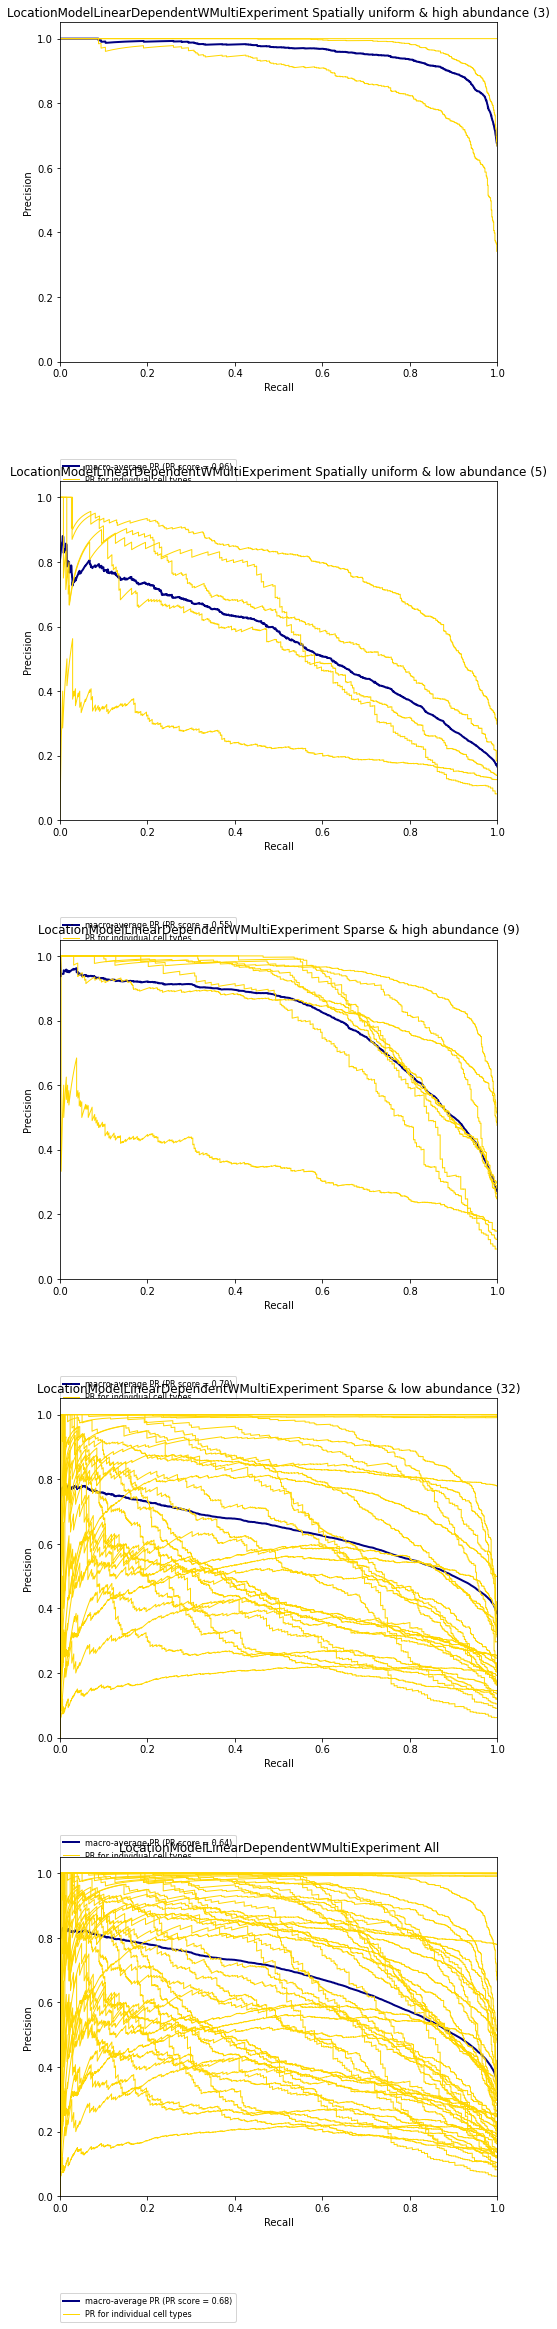

In [43]:
rcParams['figure.figsize'] = 7, 32
rcParams['pdf.fonttype'] = 42
pos_cell_count = cell_count.values > 0.1

pr_by_category(pos_cell_count, infer_cell_proportions, adata_vis_res.uns['design']['cell_types2zones'],
               nrow=5, ncol=1, title=model_name,# r['model_name'],#.__name__,
               fig_path=fig_path)
plt.tight_layout()

#### Split results by spatial distribution and abundance of cell types

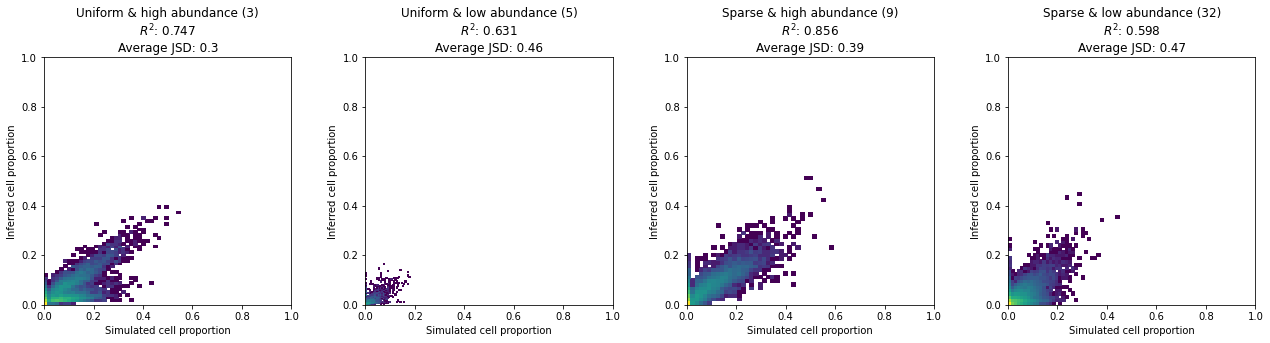

In [44]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log2(a / b), 0))
from scipy.spatial.distance import jensenshannon

def hist_obs_sim(cell_count, infer_cell_count,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 title='', compute_kl=True, equal=True, max_val=1):
    
    cor = np.round(np.corrcoef(cell_count.values.flatten(), 
               infer_cell_count.values.flatten()), 3)[0,1]
    title = title +'\n'+ r'$R^2$: ' + str(cor)
    
    if compute_kl:
        
        #kl = [KL(cell_count.values[r,:], infer_cell_count.values[r,:]) 
        #         for r in range(cell_count.shape[0])]
        js = np.array([jensenshannon(cell_count.values[r,:], infer_cell_count.values[r,:]) 
                 for r in range(cell_count.shape[0])])
        #kl = np.mean(kl)
        js = np.mean(js[~np.isnan(js)])
        #title = title + '\nAverage KL: ' + str(np.round(kl, 2))
        title = title + '\nAverage JSD: ' + str(np.round(js, 2))
    
    plt.hist2d(cell_count.values.flatten(), 
               infer_cell_count.values.flatten(),
               bins=[35, 35], norm=matplotlib.colors.LogNorm());
    plt.xlabel(xlab);
    plt.ylabel(ylab);
    if equal:
        plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, max_val);
    plt.ylim(0, max_val);
    plt.title(title);
    
def hist_by_category(cell_count, infer_cell_count, design,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 nrow=1, ncol=4, compute_kl=True, equal=True):

    design_loc = design.loc[cell_count.columns,:]
    
    max_val = np.array([cell_count.values.max(), infer_cell_count.values.max()]).max()
    if max_val < 1:
        max_val = 1
    
    plt.subplot(nrow, ncol, 1)
    ind = (design_loc['is_uniform'] * design_loc['is_high_density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Uniform & high abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)
    
    plt.subplot(nrow, ncol, 2)
    ind = (design_loc['is_uniform'] * (1 - design_loc['is_high_density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Uniform & low abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)
    
    plt.subplot(nrow, ncol, 3)
    ind = ((1 - design_loc['is_uniform']) * design_loc['is_high_density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Sparse & high abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)
    
    plt.subplot(nrow, ncol, 4)
    ind = ((1 - design_loc['is_uniform']) * (1 - design_loc['is_high_density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Sparse & low abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)
    
cell_proportions = (cell_count.T / cell_count.sum(1)).T
cell_proportions.iloc[np.isnan(cell_proportions.values)] = 0
infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T

rcParams['figure.figsize'] = 18,4.5 #9,9 #20, 4.5
rcParams["axes.facecolor"] = "white"
hist_by_category(cell_proportions, infer_cell_proportions, adata_vis_res.uns['design']['cell_types2zones'],
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 #compute_kl=False, 
                 nrow=1, ncol=4, equal=True)
plt.tight_layout()

plt.savefig(fig_path + '/hist_by_category.pdf')

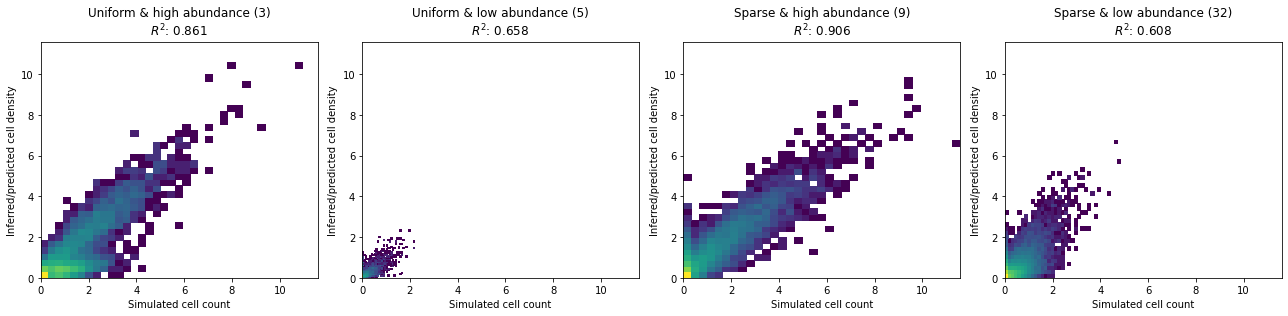

In [45]:
rcParams['figure.figsize'] = 18, 4.5
rcParams["axes.facecolor"] = "white"
hist_by_category(cell_count, infer_cell_count, adata_vis_res.uns['design']['cell_types2zones'],
                 xlab='Simulated cell count',
                 ylab='Inferred/predicted cell density',
                 compute_kl=False, equal=False)
plt.tight_layout()
plt.savefig(fig_path + '/hist_density_by_category.pdf')

plt.hist(adata_vis_res.uns['mod']['post_sample_means']['factors_per_spot'].flatten());

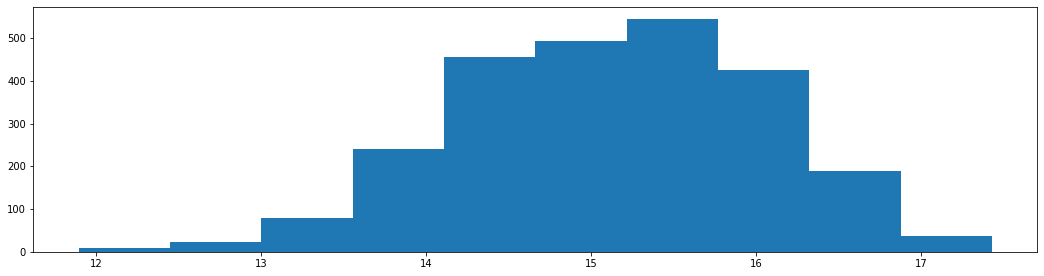

In [46]:
plt.hist(adata_vis_res.uns['mod']['post_sample_means']['combs_per_spot'].flatten());

In [47]:
combs_factors_df = pd.DataFrame(adata_vis_res.uns['mod']['post_sample_means']['combs_factors'],
                            columns=['comb_' + str(i) for i in range(adata_vis_res.uns['mod']['post_sample_means']['combs_factors'].shape[1])])
combs_factors_df

comb_0    comb_1    comb_2    comb_3    comb_4    comb_5    comb_6  \
0     0.193076  0.016744  0.018892  0.202739  0.215310  0.206479  0.292848   
1     0.352652  0.172038  0.178258  0.236419  0.187467  0.289805  0.305358   
2     0.245338  0.128913  0.022693  0.204996  0.250661  0.217517  0.217670   
3     0.219531  0.079630  0.488107  0.212049  0.180805  0.232458  0.204723   
4     0.231315  0.007524  0.583054  0.228900  0.186554  0.203055  0.131063   
...        ...       ...       ...       ...       ...       ...       ...   
2495  0.250833  0.027699  0.101497  0.184453  0.461440  0.252892  0.228394   
2496  0.173991  0.081459  0.146837  0.190376  0.212778  0.206732  0.116812   
2497  0.195522  0.031188  0.216050  0.244991  0.247249  0.298835  0.215190   
2498  0.244813  0.123165  0.611180  0.362900  0.278833  0.249255  0.288277   
2499  0.166984  0.031967  0.058483  0.139631  0.264316  0.171772  0.180582   

        comb_7    comb_8    comb_9  ...   comb_40   comb_41   comb_42  \
0     0.226068  0.233029  0.210737  ...  0.162452  0.204587  0.165021   
1     0.172474  0.255798  0.171501  ...  0.206576  0.180028  0.591134   
2     0.193565  0.295162  0.198375  ...  0.279874  0.155932  0.209022   
3     0.255545  0.268538  0.204708  ...  0.219008  0.170707  0.252607   
4     0.248433  0.167854  0.132439  ...  0.221004  0.180897  0.287813   
...        ...       ...       ...  ...       ...       ...       ...   
2495  0.237788  0.207645  0.252399  ...  0.261907  0.247838  0.251826   
2496  0.177611  0.294213  0.240236  ...  0.173044  0.272477  0.202961   
2497  0.357112  0.222398  0.308345  ...  0.270266  0.258685  0.251866   
2498  0.246709  0.342800  0.283729  ...  0.269458  0.254279  0.791806   
2499  0.192718  0.138343  0.155005  ...  0.178965  0.161901  0.161258   

       comb_43   comb_44   comb_45   comb_46   comb_47   comb_48   comb_49  
0     0.220535  0.211145  0.213895  0.178625  0.149294  0.314197  0.198580  
1     0.299581  0.224740  0.210589  0.302644  0.186447  0.165977  0.214520  
2     0.329262  0.232637  0.176217  0.150995  0.173126  0.182750  0.222857  
3     0.240952  0.260941  0.224370  0.189163  0.254746  0.243050  0.216630  
4     0.200383  0.128027  0.147532  0.199926  0.195556  0.173882  0.206133  
...        ...       ...       ...       ...       ...       ...       ...  
2495  0.184448  0.276191  0.231544  0.228563  0.285900  0.174542  0.186056  
2496  0.220454  0.202624  0.175660  0.270375  0.336825  0.358022  0.170819  
2497  0.214280  0.306452  0.202758  0.426472  0.277741  0.241556  0.337585  
2498  0.225237  0.191233  0.269498  0.200987  0.161186  0.263085  0.175131  
2499  0.210730  0.211410  0.207489  0.218681  0.179822  0.176657  0.186832  

[2500 rows x 50 columns]

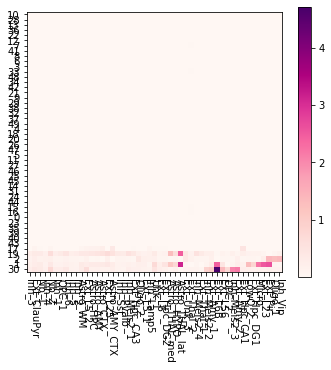

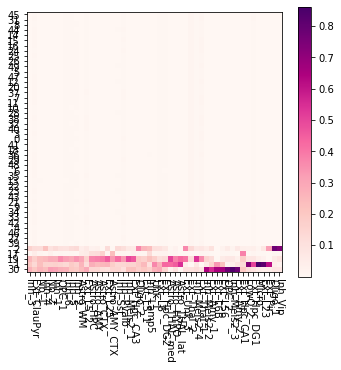

In [48]:
from cell2location.plt.plot_heatmap import clustermap
comb2fact_df = pd.DataFrame(adata_vis_res.uns['mod']['post_sample_means']['comb2fact'],
                            columns=adata_vis_res.uns['mod']['fact_names'])
comb2fact_df_prop = (comb2fact_df / comb2fact_df.sum(0))
clustermap(comb2fact_df)
clustermap(comb2fact_df_prop)

#### Stratify cell types by their size in the reference

In [49]:
gene_factors = pd.DataFrame(adata_vis_res.uns['mod']['post_sample_means']['gene_factors'],
                            index=adata_vis_res.uns['mod']['var_names'],
                            columns=adata_vis_res.uns['mod']['fact_names'])

Index(['Astro_AMY_CTX', 'Astro_THAL_lat', 'Astro_WM', 'Oligo_2'], dtype='object')

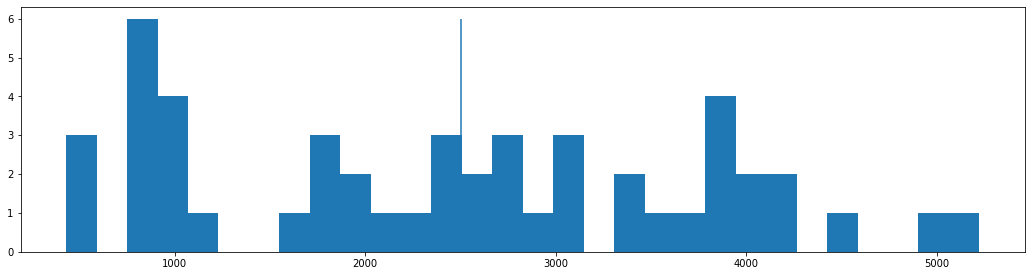

In [50]:
plt.hist(gene_factors.sum(0), bins=30);
plt.vlines(2500, 0, 6);
small_ind = np.array(gene_factors.sum(0) < 2500) \
& (adata_vis_res.uns['design']['cell_types2zones']['is_high_density']).values.astype(bool)
gene_factors.columns[small_ind]

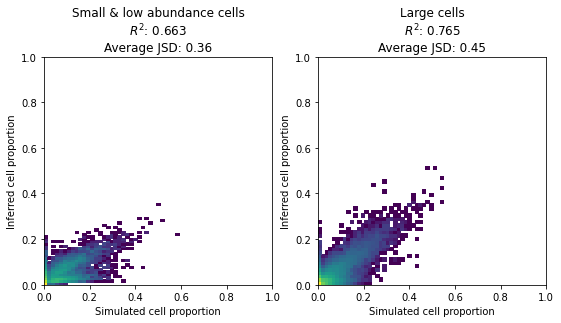

In [51]:
def hist_by_category2(cell_count, infer_cell_count, index,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='', name2='',
                 nrow=1, ncol=4, compute_kl=True, equal=True):

    design_loc = adata_vis_res.uns['design']['cell_types2zones'].loc[cell_count.columns,:]
    
    plt.subplot(nrow, ncol, 1)
    hist_obs_sim(cell_count.loc[:,index], infer_cell_count.loc[:,index.astype(bool)],
                 xlab=xlab,
                 ylab=ylab,
                 title=name1,
                 compute_kl=compute_kl, equal=equal)
    
    plt.subplot(nrow, ncol, 2)
    hist_obs_sim(cell_count.loc[:,~index], infer_cell_count.loc[:,~index.astype(bool)],
                 xlab=xlab,
                 ylab=ylab,
                 title=name2,
                 compute_kl=compute_kl, equal=equal)
    
rcParams['figure.figsize'] = 9, 4.5
rcParams["axes.facecolor"] = "white"

hist_by_category2(cell_proportions, infer_cell_proportions, small_ind,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=True)

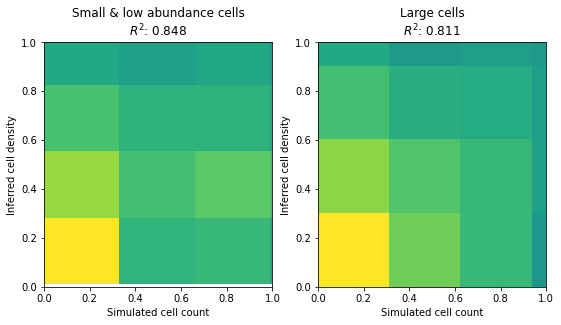

In [52]:
hist_by_category2(cell_count, infer_cell_count, small_ind,
                 xlab='Simulated cell count',
                 ylab='Inferred cell density',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=False, equal=False)

### Evaluate inferred gene expression level difference between technologies (`gene_level`)

In [53]:
gene_level = pd.DataFrame(adata_vis_res.uns['mod']['post_sample_means']['gene_level'].flatten(),
                 index=adata_vis_res.uns['mod']['var_names'],
                 columns=['inferred_gene_level'])
adata_vis_res.var['inferred_gene_level'] = gene_level.reindex(index=adata_vis_res.var_names)['inferred_gene_level']

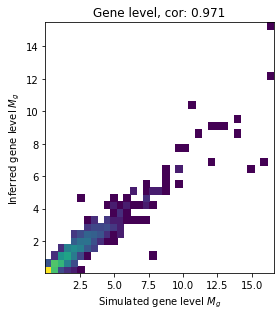

In [54]:
rcParams['figure.figsize'] = 4, 4.5
var = adata_vis_res.var
var = var.loc[~var['inferred_gene_level'].isna(),:]
plt.hist2d(var['gene_level'].values.flatten(), 
           var['inferred_gene_level'].values.flatten(),
           bins=35, norm=matplotlib.colors.LogNorm());
plt.xlabel(r'Simulated gene level $M_g$');
plt.ylabel('Inferred gene level $M_g$');
#plt.xlim(0, 1);
#plt.ylim(0, 1);
plt.title('Gene level, cor: ' \
          + str(np.round(np.corrcoef(var['gene_level'].values.flatten(), 
                var['inferred_gene_level'].values.flatten()), 3)[0,1]));
plt.tight_layout();
plt.savefig(fig_path + '/hist_gene_level.pdf')

### Evaluate inferred cell density inferred with stereoscope

In [55]:
stereo_path_1 = f'{results_folder}scvi_stereoscope/'
scvi_stereoscope = anndata.read(f'{stereo_path_1}sp_n_epochs30k.h5ad')

scvi_stereoscope = scvi_stereoscope.obsm['decomposition'].copy()
scvi_stereoscope = (scvi_stereoscope.T / scvi_stereoscope.sum(1)).T
scvi_stereoscope = scvi_stereoscope.loc[cell_count.index,:]

In [56]:
stereo_df = scvi_stereoscope[cell_count.columns]

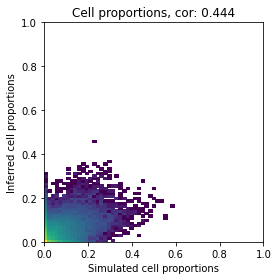

In [57]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_proportions.values.flatten(), 
           stereo_df.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell proportions');
plt.ylabel('Inferred cell proportions');
plt.title('Cell proportions, cor: ' \
          + str(np.round(np.corrcoef(cell_proportions.values.flatten(), 
           stereo_df.values.flatten()), 3)[0,1]));
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 1);
plt.ylim(0, 1);
plt.tight_layout();

plt.savefig(os.path.split(stereo_path_1)[0] + '/Cell_proportion_cor.pdf')

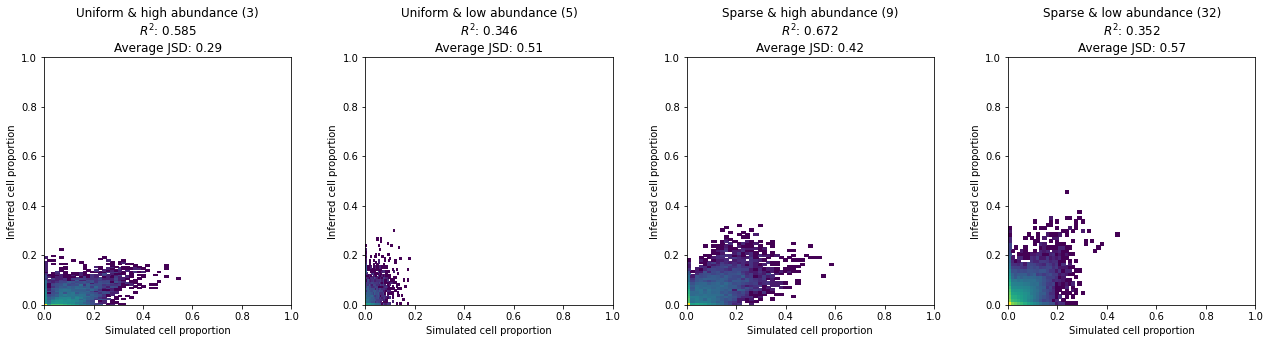

In [58]:
rcParams['figure.figsize'] = 18, 4.5
hist_by_category(cell_proportions, stereo_df, adata_vis_res.uns['design']['cell_types2zones'],
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion')
plt.tight_layout()

plt.savefig(os.path.split(stereo_path_1)[0] + '/Cell_proportion_cor_by_group.pdf')

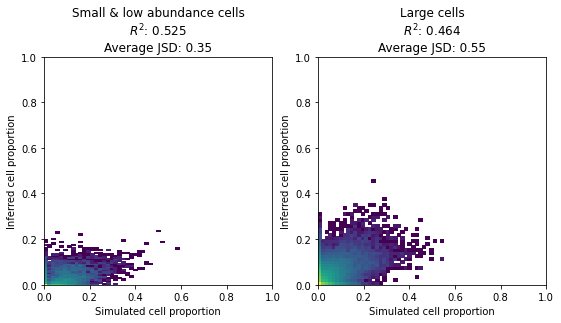

In [59]:
rcParams['figure.figsize'] = 9, 4.5
hist_by_category2(cell_proportions, stereo_df, small_ind,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=True)

plt.savefig(os.path.split(stereo_path_1)[0] + '/Cell_proportion_cor_by_size.pdf')

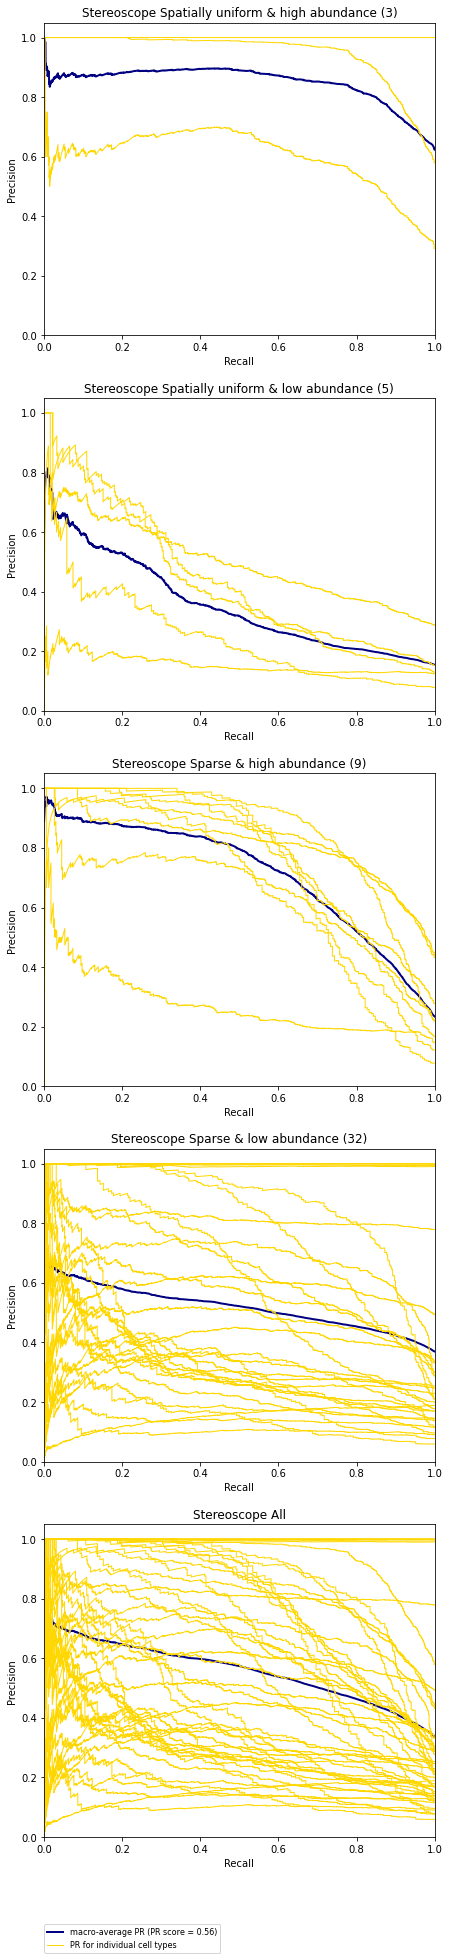

In [60]:
rcParams['figure.figsize'] = 7, 40
pos_cell_count = cell_count.values > 0.1
pr_by_category(pos_cell_count, stereo_df, adata_vis_res.uns['design']['cell_types2zones'],
                 nrow=5, ncol=1,
                      title='Stereoscope')

plt.savefig(os.path.split(stereo_path_1)[0] + '/ROC_all.pdf')

### Evaluate inferred cell density inferred with nnls (autogenes)

In [61]:
# read cell proportions
nnls_path_1 = results_folder + 'autogenes_models/coef_nnls_seed.csv'
nnls_df = pd.read_csv(nnls_path_1, sep=',', index_col=0).T

# compute proportions per location
nnls_df = (nnls_df.T / nnls_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
nnls_df = nnls_df.loc[nnls_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[nnls_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]

Trying to set attribute `.obs` of view, copying.


In [62]:
nnls_df = nnls_df[cell_count.columns]

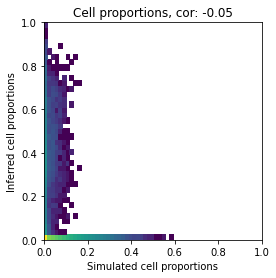

In [63]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_proportions.values.flatten(), 
           nnls_df.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell proportions');
plt.ylabel('Inferred cell proportions');
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 1);
plt.ylim(0, 1);
plt.title('Cell proportions, cor: ' \
          + str(np.round(np.corrcoef(cell_proportions.values.flatten(), 
           nnls_df.values.flatten()), 3)[0,1]));

plt.savefig(os.path.split(nnls_path_1)[0] + '/Cell_proportion_cor.pdf')

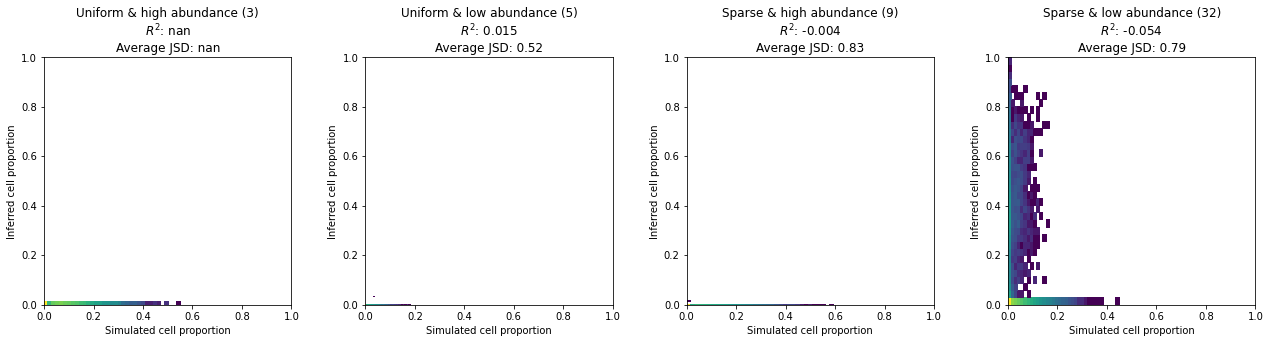

In [64]:
rcParams['figure.figsize'] = 18, 4.5
hist_by_category(cell_proportions, nnls_df, adata_vis_res.uns['design']['cell_types2zones'],
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion')
plt.tight_layout()

plt.savefig(os.path.split(nnls_path_1)[0] + '/Cell_proportion_cor_by_group.pdf')

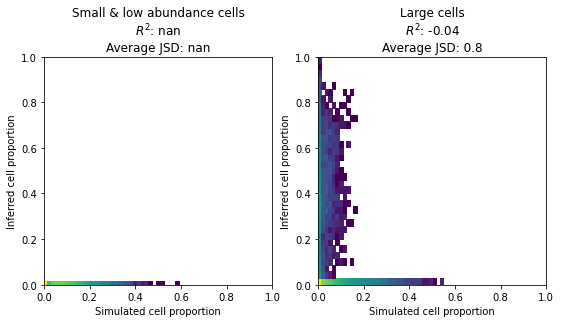

In [65]:
rcParams['figure.figsize'] = 9, 4.5
hist_by_category2(cell_proportions, nnls_df, small_ind,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=True)

plt.savefig(os.path.split(nnls_path_1)[0] + '/Cell_proportion_cor_by_size.pdf')

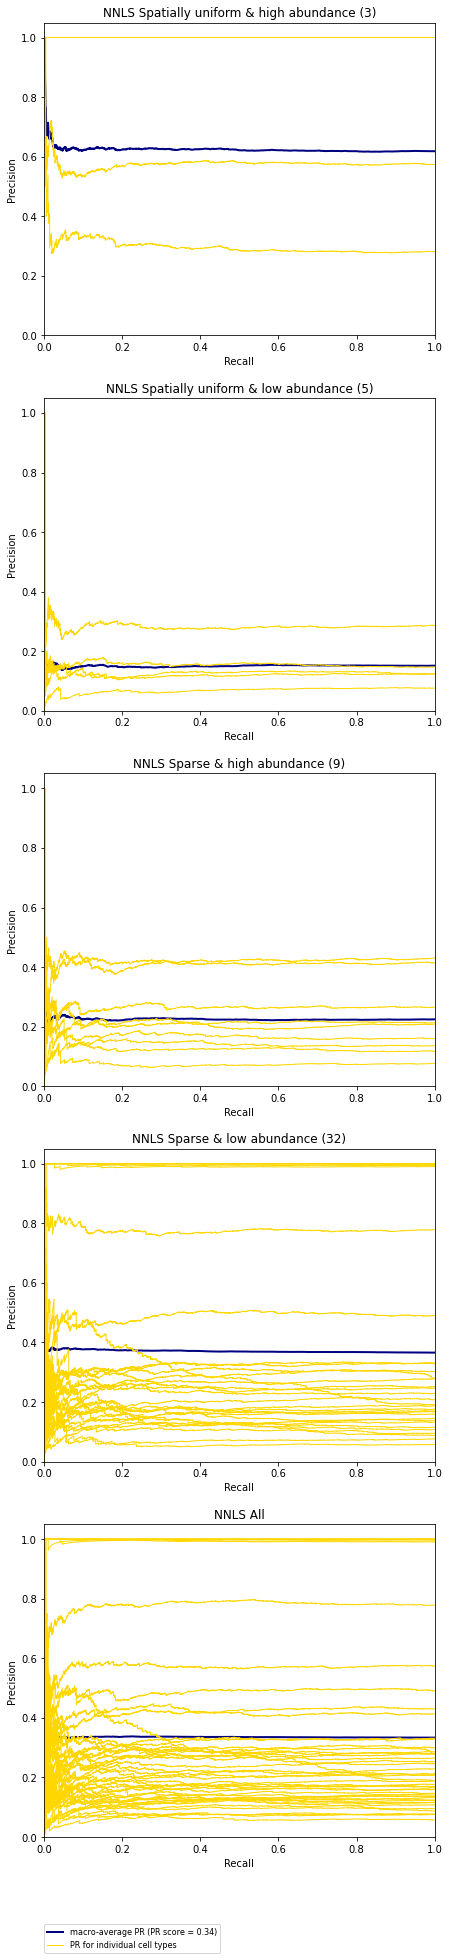

In [66]:
rcParams['figure.figsize'] = 7, 40
pos_cell_count = cell_count.values > 0.1
pr_by_category(pos_cell_count, nnls_df, adata_vis_res.uns['design']['cell_types2zones'],
                 nrow=5, ncol=1,
                      title='NNLS')

plt.savefig(os.path.split(nnls_path_1)[0] + '/ROC_all.pdf')

### Evaluate inferred cell density inferred with RCTD

In [67]:
# read cell proportions
RCTD_path_1 = results_folder + 'rctd/results_weights.csv'
RCTD_df = pd.read_csv(RCTD_path_1, sep=',', index_col='spot')

# compute proportions per location
RCTD_df_orig = RCTD_df.copy()
RCTD_df = (RCTD_df.T / RCTD_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
RCTD_df = RCTD_df.loc[RCTD_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[RCTD_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]

Trying to set attribute `.obs` of view, copying.


In [68]:
RCTD_df = RCTD_df[cell_count.columns]
RCTD_df_orig = RCTD_df_orig[cell_count.columns]

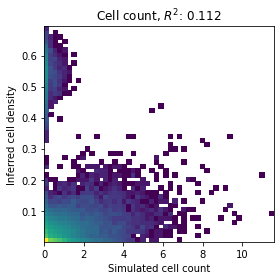

In [69]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_count.values.flatten(), 
           RCTD_df_orig.values.flatten(),# / np.mean(adata_vis_res.var['gene_level'].values),
           bins=[50, 50], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell count');
plt.ylabel('Inferred cell density');
plt.title(r'Cell count, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           RCTD_df_orig.values.flatten()), 3)[0,1]));
#plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig(os.path.split(RCTD_path_1)[0] + '/RCTD_Cell_density_cor.pdf')

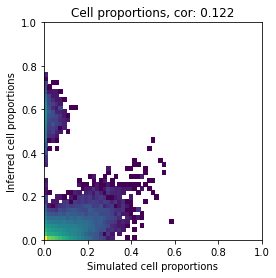

In [70]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_proportions.values.flatten(), 
           RCTD_df.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell proportions');
plt.ylabel('Inferred cell proportions');
plt.xlim(0, 1);
plt.ylim(0, 1);
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Cell proportions, cor: ' \
          + str(np.round(np.corrcoef(cell_proportions.values.flatten(), 
           RCTD_df.values.flatten()), 3)[0,1]));

plt.savefig(os.path.split(RCTD_path_1)[0] + '/Cell_proportion_cor.pdf')

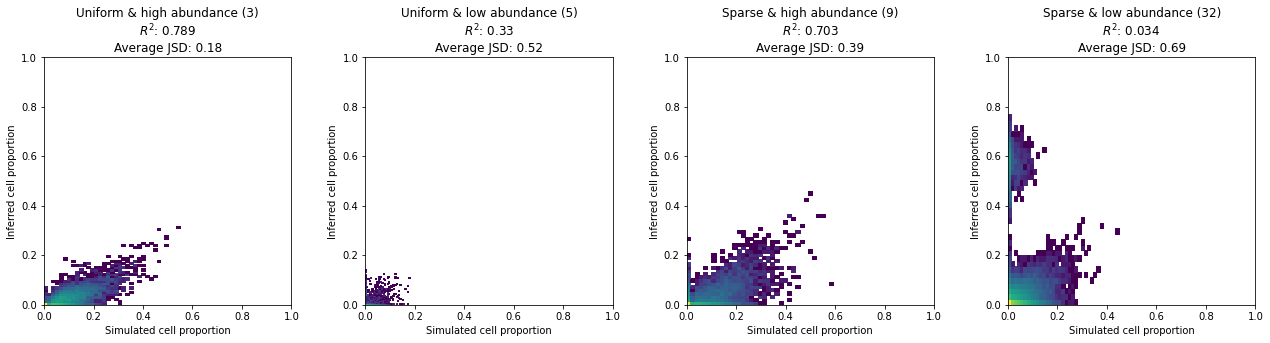

In [71]:
rcParams['figure.figsize'] = 18, 4.5
hist_by_category(cell_proportions, RCTD_df, adata_vis_res.uns['design']['cell_types2zones'],
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion')
plt.tight_layout()

plt.savefig(os.path.split(RCTD_path_1)[0] + '/Cell_proportion_cor_by_group.pdf')

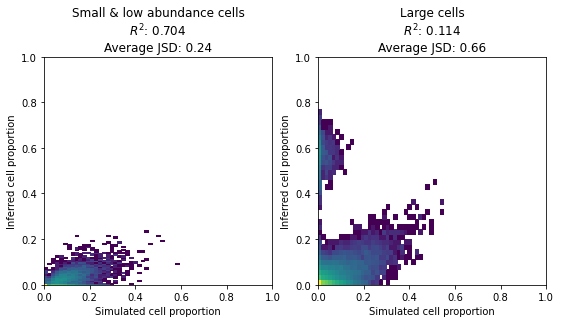

In [72]:
rcParams['figure.figsize'] = 9, 4.5
hist_by_category2(cell_proportions, RCTD_df, small_ind,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=True)

plt.savefig(os.path.split(RCTD_path_1)[0] + '/Cell_proportion_cor_by_size.pdf')

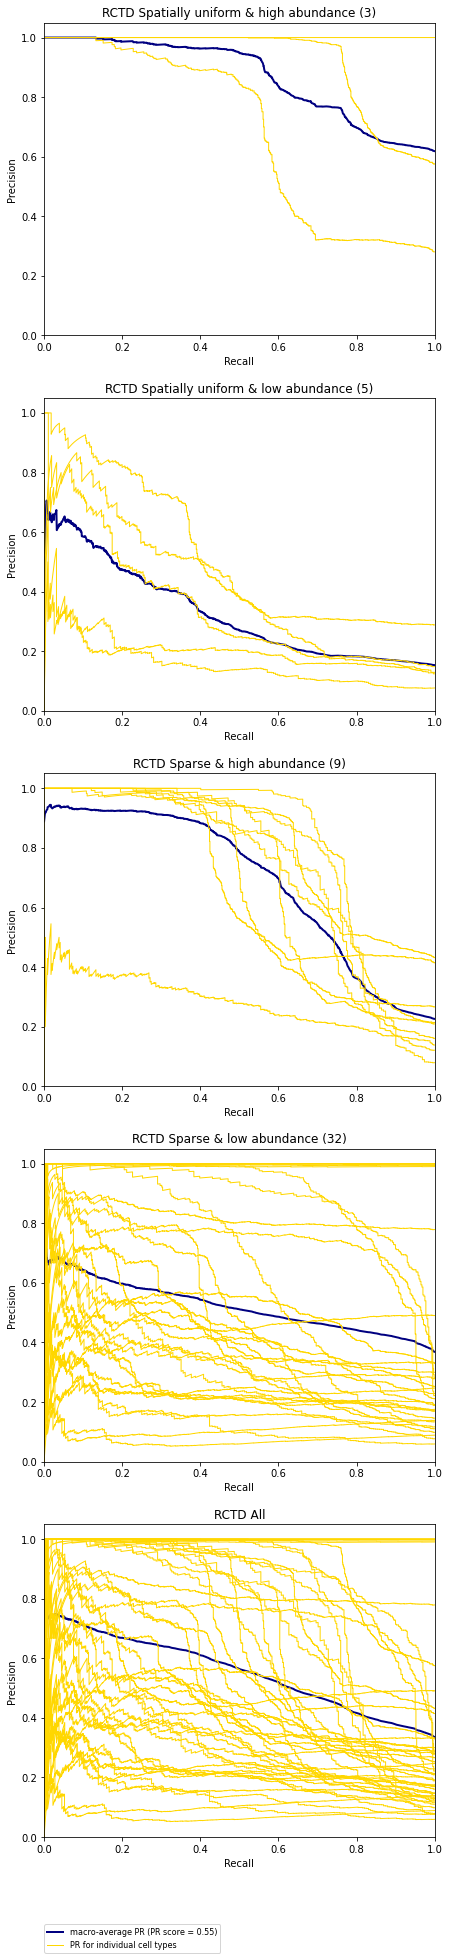

In [73]:
rcParams['figure.figsize'] = 7, 40
pos_cell_count = cell_count.values > 0.1
pr_by_category(pos_cell_count, RCTD_df, adata_vis_res.uns['design']['cell_types2zones'],
                 nrow=5, ncol=1,
                      title='RCTD')

plt.savefig(os.path.split(RCTD_path_1)[0] + '/ROC_all.pdf')

### Evaluate inferred cell propotion inferred with Seurat 3

In [74]:
# read cell proportions
seurat_path_1 = results_folder + 'seurat/results_pca.csv'
seurat_df = pd.read_csv(seurat_path_1, sep=',', index_col='spot')
seurat_df = seurat_df.drop(columns=['predicted.id', 'prediction.score.max', 'Unnamed: 0'])
from re import sub
seurat_df.columns = [sub('prediction.score.', '', i) for i in seurat_df.columns]

# compute proportions per location
seurat_df = (seurat_df.T / seurat_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
seurat_df = seurat_df.loc[seurat_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[seurat_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]

Trying to set attribute `.obs` of view, copying.


In [75]:
seurat_df = seurat_df[cell_count.columns]

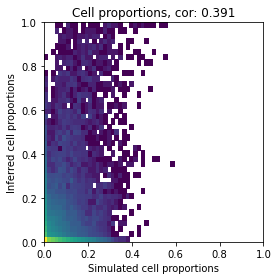

In [76]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_proportions.values.flatten(), 
           seurat_df.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell proportions');
plt.ylabel('Inferred cell proportions');
plt.title('Cell proportions, cor: ' \
          + str(np.round(np.corrcoef(cell_proportions.values.flatten(), 
           seurat_df.values.flatten()), 3)[0,1]));
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 1);
plt.ylim(0, 1);
plt.tight_layout();

plt.savefig(os.path.split(seurat_path_1)[0] + '/Cell_proportion_cor.pdf')

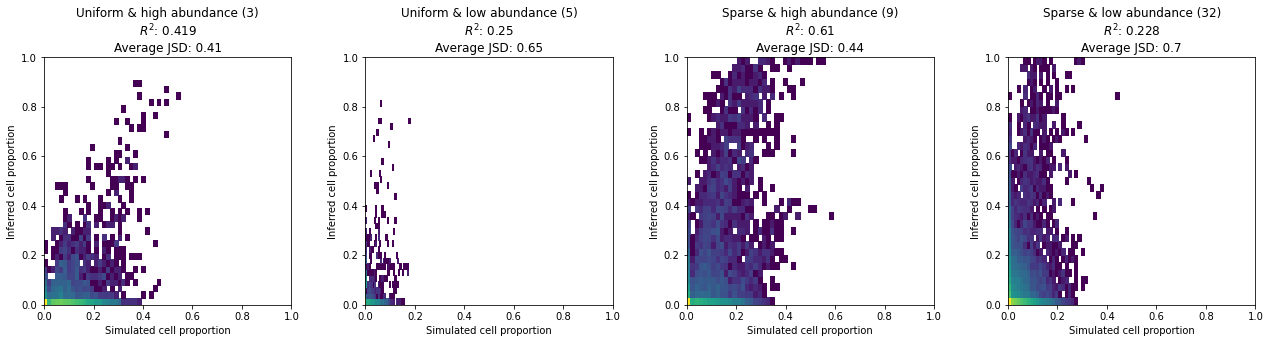

In [77]:
rcParams['figure.figsize'] = 18, 4.5
hist_by_category(cell_proportions, seurat_df, adata_vis_res.uns['design']['cell_types2zones'],
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion')
plt.tight_layout()

plt.savefig(os.path.split(seurat_path_1)[0] + '/Cell_proportion_cor_by_group.pdf')

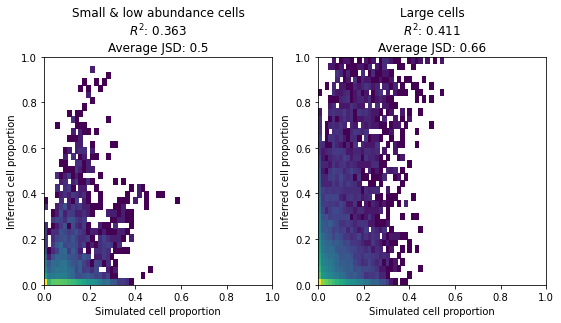

In [78]:
rcParams['figure.figsize'] = 9, 4.5
hist_by_category2(cell_proportions, seurat_df, small_ind,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=True)

plt.savefig(os.path.split(seurat_path_1)[0] + '/Cell_proportion_cor_by_size.pdf')

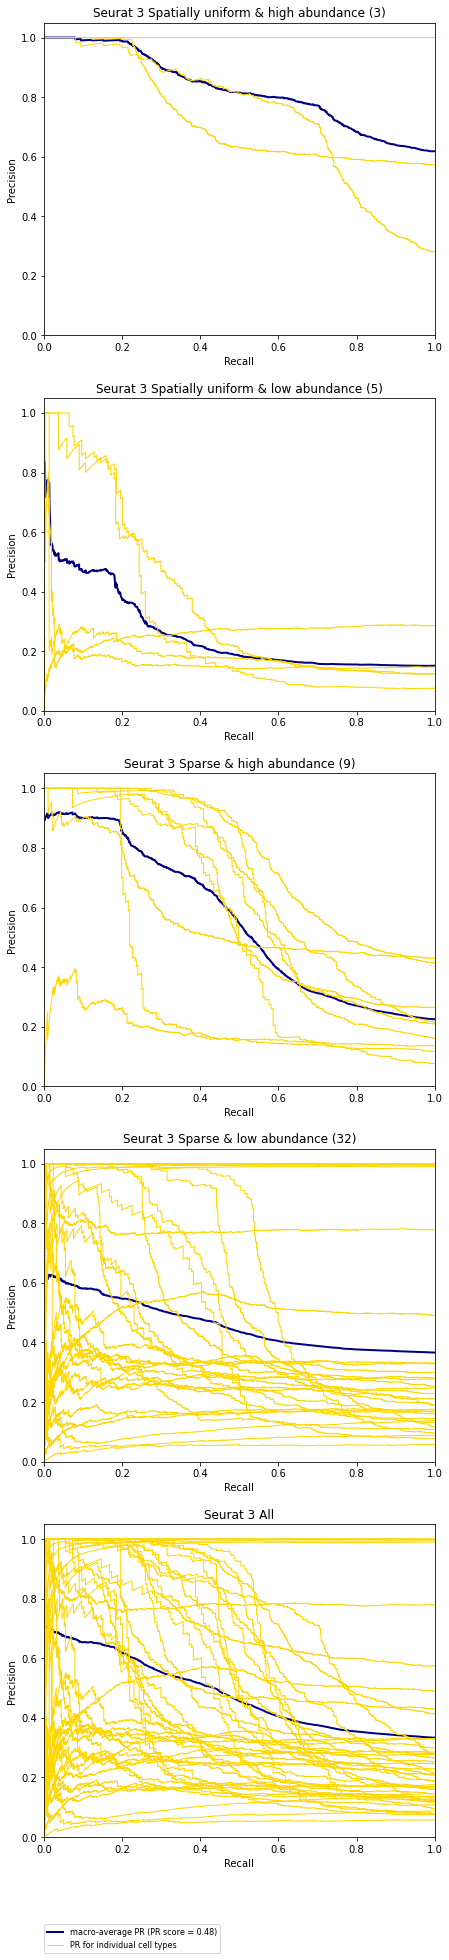

In [79]:
rcParams['figure.figsize'] = 7, 40
pos_cell_count = cell_count.values > 0.1
pr_by_category(pos_cell_count, seurat_df, adata_vis_res.uns['design']['cell_types2zones'],
                 nrow=5, ncol=1,
                      title='Seurat 3',
               fig_path=fig_path)

plt.savefig(os.path.split(seurat_path_1)[0] + '/ROC_all.pdf')

In [80]:
# read cell proportions
seurat_path_1 = results_folder + 'seurat/results_cca.csv'
seurat_cca_df = pd.read_csv(seurat_path_1, sep=',', index_col='spot')
seurat_cca_df = seurat_cca_df.drop(columns=['predicted.id', 'prediction.score.max', 'Unnamed: 0'])
from re import sub
seurat_cca_df.columns = [sub('prediction.score.', '', i) for i in seurat_cca_df.columns]

# compute proportions per location
seurat_cca_df = (seurat_cca_df.T / seurat_cca_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
seurat_cca_df = seurat_cca_df.loc[seurat_cca_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[seurat_cca_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]

Trying to set attribute `.obs` of view, copying.


In [81]:
seurat_cca_df = seurat_cca_df[cell_count.columns]

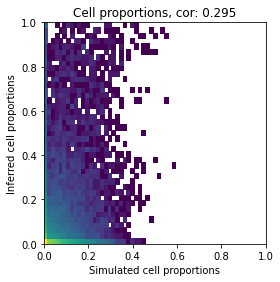

In [82]:
rcParams['figure.figsize'] = 4, 4.5
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_proportions.values.flatten(), 
           seurat_cca_df.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell proportions');
plt.ylabel('Inferred cell proportions');
plt.title('Cell proportions, cor: ' \
          + str(np.round(np.corrcoef(cell_proportions.values.flatten(), 
           seurat_cca_df.values.flatten()), 3)[0,1]));
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 1);
plt.ylim(0, 1);
plt.tight_layout();

plt.savefig(os.path.split(seurat_path_1)[0] + '/cca_Cell_proportion_cor.pdf')

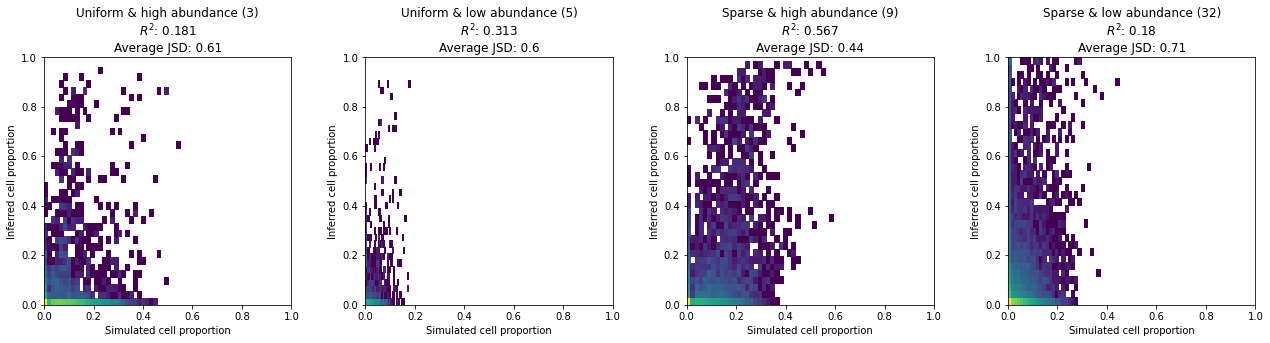

In [83]:
rcParams['figure.figsize'] = 18, 4.5
hist_by_category(cell_proportions, seurat_cca_df, adata_vis_res.uns['design']['cell_types2zones'],
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion')
plt.tight_layout()

plt.savefig(os.path.split(seurat_path_1)[0] + '/cca_Cell_proportion_cor_by_group.pdf')

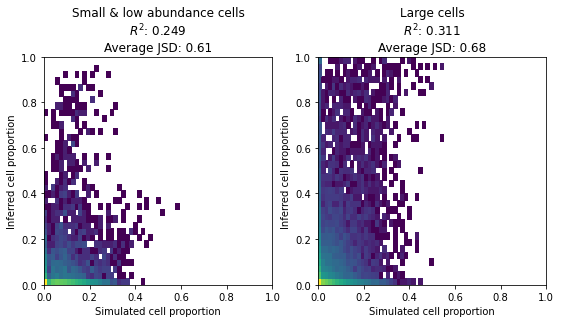

In [84]:
rcParams['figure.figsize'] = 9, 4.5
hist_by_category2(cell_proportions, seurat_cca_df, small_ind,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=True)

plt.savefig(os.path.split(seurat_path_1)[0] + '/cca_Cell_proportion_cor_by_size.pdf')

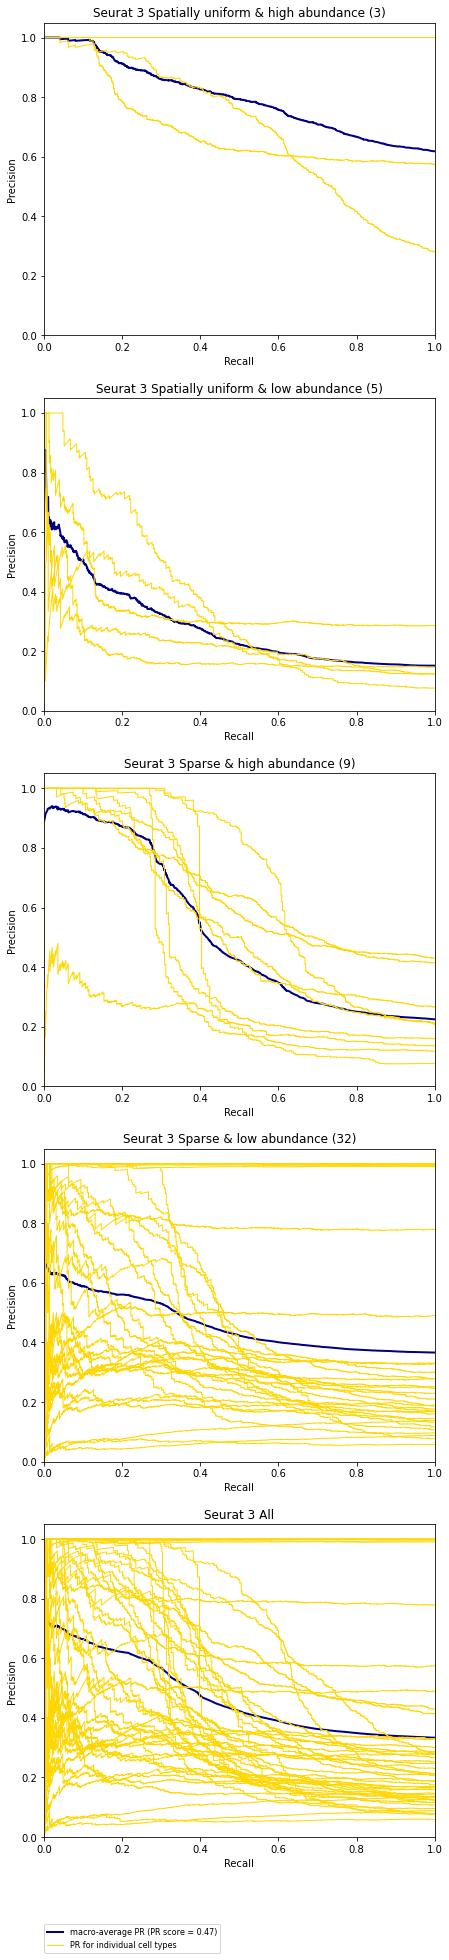

In [85]:
rcParams['figure.figsize'] = 7, 40
pos_cell_count = cell_count.values > 0.1
pr_by_category(pos_cell_count, seurat_cca_df, adata_vis_res.uns['design']['cell_types2zones'],
                 nrow=5, ncol=1,
                      title='Seurat 3',
               fig_path=fig_path)

plt.savefig(os.path.split(seurat_path_1)[0] + '/cca_ROC_all.pdf')

### Evaluate inferred cell propotion inferred with SPOTlight

In [86]:
# read cell proportions
spotlight_path_1 = results_folder + 'SPOTlight/results_hvg5k.csv'
spotlight_df = pd.read_csv(spotlight_path_1, sep=',', index_col='rn')
spotlight_df = spotlight_df.drop(columns=['res_ss'])

from re import sub

seu_index = [sub(' ', '.',i) for i in cell_proportions.columns]
seu_index = [sub('/', '.',i) for i in seu_index]
seu_index = [sub('-', '.',i) for i in seu_index]
seu_index = [sub('_', '.',i) for i in seu_index]

spotlight_df = spotlight_df[seu_index]
spotlight_df.columns = cell_proportions.columns

# compute proportions per location (already proportions)
#spotlight_df = (spotlight_df.T / spotlight_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
spotlight_df = spotlight_df.loc[spotlight_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[spotlight_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]

Trying to set attribute `.obs` of view, copying.


In [87]:
spotlight_df = spotlight_df[cell_count.columns]

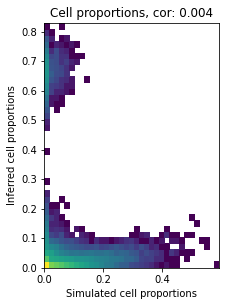

In [88]:
rcParams['figure.figsize'] = 4, 4.5
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_proportions.values.flatten(), 
           spotlight_df.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell proportions');
plt.ylabel('Inferred cell proportions');
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Cell proportions, cor: ' \
          + str(np.round(np.corrcoef(cell_proportions.values.flatten(), 
           spotlight_df.values.flatten()), 3)[0,1]));

plt.savefig(os.path.split(spotlight_path_1)[0] + '/spotlightCell_proportion_cor.pdf')

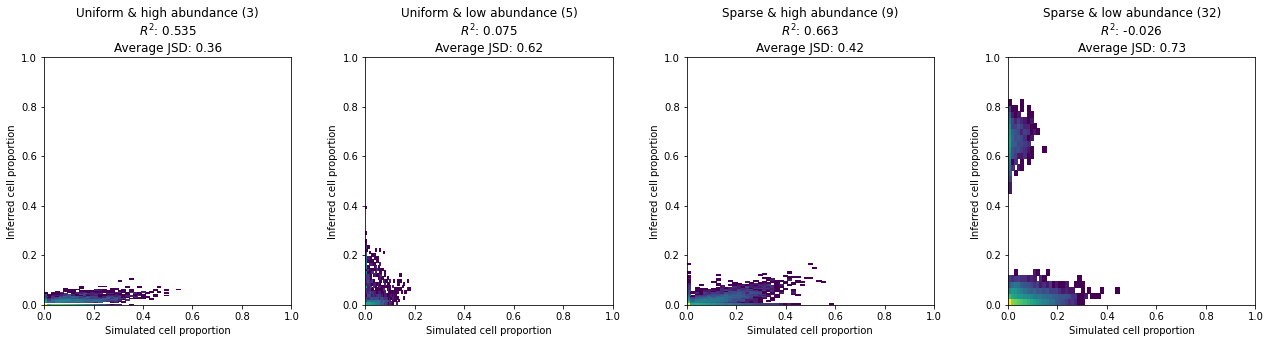

In [89]:
rcParams['figure.figsize'] = 18, 4.5
hist_by_category(cell_proportions, spotlight_df, adata_vis_res.uns['design']['cell_types2zones'],
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion')
plt.tight_layout()

plt.savefig(os.path.split(spotlight_path_1)[0] + '/spotlightCell_proportion_cor_by_group.pdf')

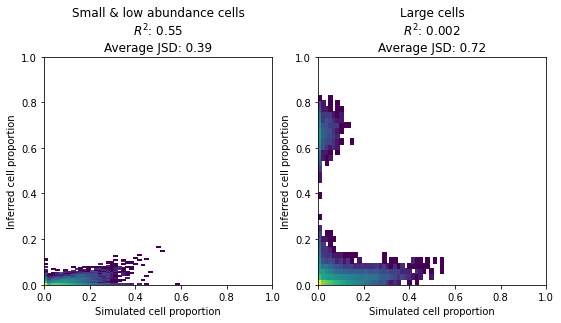

In [90]:
rcParams['figure.figsize'] = 9, 4.5
hist_by_category2(cell_proportions, spotlight_df, small_ind,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=True)

plt.savefig(os.path.split(spotlight_path_1)[0] + '/spotlightCell_proportion_cor_by_size.pdf')

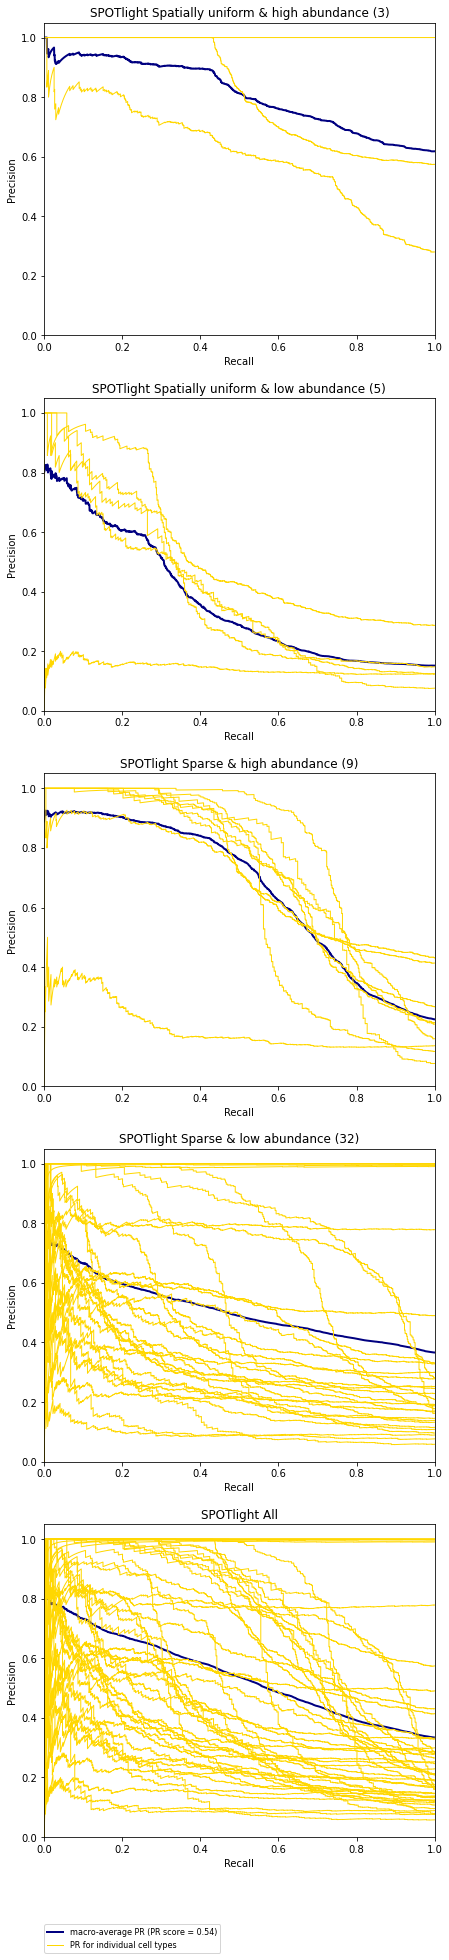

In [91]:
rcParams['figure.figsize'] = 7, 40
pos_cell_count = cell_count.values > 0.1
pr_by_category(pos_cell_count, spotlight_df, adata_vis_res.uns['design']['cell_types2zones'],
                 nrow=5, ncol=1,
                      title='SPOTlight',
               fig_path=fig_path)

plt.savefig(os.path.split(spotlight_path_1)[0] + '/spotlightROC_all.pdf')

## Compare per-spot accuracy of cell2location and stereoscope

### Compare the stereoscope and our model using precision-recall

In [92]:
import matplotlib as mpl
from matplotlib import pyplot as plt

with plt.style.context('seaborn'):
    seaborn_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
seaborn_colors
sc.pl.palettes.default_102

def compare_precision_recall(pos_cell_count, infer_cell_proportions,
                             method_title, title='',
                             legend_loc=(0, -.37),
                             colors=sc.pl.palettes.default_102,
                             mode='macro', curve='PR'):
    
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells), 
                                        list of inferred parameters for several methods
    :param method_title: title for each infer_cell_proportions
    :param title: plot title
    """
    # setup plot details
    from itertools import cycle
    colors = cycle(colors)
    lines = []
    labels = []
    roc = {}
    
    ### plotting ###
    for i, color in zip(range(len(infer_cell_proportions)), colors):
        
        if curve == 'PR':
            precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'Recall'
            ylabel = 'Precision'
            
            l, = plt.plot(recall["averaged"], precision["averaged"], color=color, lw=3)

        elif curve == 'ROC':
            FPR, TPR, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'FPR'
            ylabel = 'TPR'
            
            l, = plt.plot(FPR["averaged"], TPR["averaged"], color=color, lw=3)
            
        
        lines.append(l)

        labels.append(method_title[i] + ' (area = {0:0.2f})'
                      ''.format(average_precision["averaged"]))
        roc[method_title[i]] = average_precision["averaged"]


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend_loc is not None:
        plt.legend(lines, labels, loc=legend_loc, prop=dict(size=14))

    #plt.show()
    return roc
    
def read_cell_maps(results_folder, run_name, cell_count, post_type='mean'):
    
    # read anndata object, extract data
    sp_data_file = results_folder + run_name + '/sp.h5ad'
    adata_vis_res = anndata.read(sp_data_file)
    
    # read pickle with extra info
    file = results_folder + run_name+'/model_.p'
    r = pickle.load(file = open(file, "rb"))
    
    # extract data
    from re import sub
    cell_count_columns = cell_count.columns

    spot_factors = adata_vis_res.obs[[post_type + '_spot_factors' + i for i in cell_count_columns]]
    spot_factors.columns =  [sub(post_type + '_spot_factors', '', i) for i in spot_factors.columns]

    #spot_factors_sd = adata_vis_res.obs[['sd_spot_factors' + i for i in cell_count_columns]]
    #spot_factors_sd.columns =  [sub('sd_spot_factors', '', i) for i in spot_factors_sd.columns]

    nUMI_factors = adata_vis_res.obs[[post_type + '_nUMI_factors' + i for i in cell_count_columns]]
    nUMI_factors.columns =  [sub(post_type + '_nUMI_factors', '', i) for i in nUMI_factors.columns]
    
    #spot_factors = spot_factors / spot_factors_sd

    infer_cell_count = spot_factors[cell_count.columns]
    infer_nUMI_count = nUMI_factors[cell_count.columns]
    
    infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T
    
    return r['model_name'], infer_cell_proportions, infer_cell_count, infer_nUMI_count # spot_factors_sd

In [97]:
names = []
results = []
names_count = []
results_count = []
results_q05 = []
results_count_q05 = []

run_names = [
    'LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_6565genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2',
    'LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2',
    'LocationModelLinearDependentWMultiExperimentNoMg_1experiments_49clusters_2500locations_12080genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2',
    'LocationModelHierarchicalWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2',
    'LocationModelMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2',
    'LocationModelLinearDependentWMultiExperimentNoSegLs_1experiments_49clusters_2500locations_12080genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2',
    'LocationModelLinearDependentWMultiExperimentLocationBackgroundNormGeneAlpha_1experiments_49clusters_2500locations_12080genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2',
            ]

for n in run_names:
    name, infer_cell_prop, infer_cell_count, infer_nUMI_count = \
    read_cell_maps(results_folder, n, cell_count, post_type='mean')
    #infer_cell_count = (infer_cell_count.T / infer_cell_count.max(1)).T
    names.append(name)
    results.append(infer_cell_prop)
    names_count.append(name)
    results_count.append(infer_cell_count)
    
    name, infer_cell_prop, infer_cell_count, infer_nUMI_count = \
    read_cell_maps(results_folder, n, cell_count, post_type='q05')
    #infer_cell_count = (infer_cell_count.T / infer_cell_count.max(1)).T
    results_q05.append(infer_cell_prop)
    results_count_q05.append(infer_cell_count)

# add stereoscope
results.append(stereo_df[cell_count.columns])
results_count.append(stereo_df[cell_count.columns])
results_q05.append(stereo_df[cell_count.columns])
results_count_q05.append(stereo_df[cell_count.columns])
names.append('Stereoscope')

# add RCTD_df
results.append(RCTD_df[cell_count.columns])
results_count.append(RCTD_df[cell_count.columns])
results_q05.append(RCTD_df[cell_count.columns])
results_count_q05.append(RCTD_df[cell_count.columns])
names.append('RCTD')

# add Seurat 3
results.append(seurat_df[cell_count.columns])
results_count.append(seurat_df[cell_count.columns])
results_q05.append(seurat_df[cell_count.columns])
results_count_q05.append(seurat_df[cell_count.columns])
names.append('Seurat 3 PCA')

# add Seurat 3
results.append(seurat_cca_df[cell_count.columns])
results_count.append(seurat_cca_df[cell_count.columns])
results_q05.append(seurat_cca_df[cell_count.columns])
results_count_q05.append(seurat_cca_df[cell_count.columns])
names.append('Seurat 3 CCA')

# add SPOTlight
results.append(spotlight_df[cell_count.columns])
results_count.append(spotlight_df[cell_count.columns])
results_q05.append(spotlight_df[cell_count.columns])
results_count_q05.append(spotlight_df[cell_count.columns])
names.append('SPOTlight')

# add NNLS
results.append(nnls_df[cell_count.columns])
results_count.append(nnls_df[cell_count.columns])
results_q05.append(nnls_df[cell_count.columns])
results_count_q05.append(nnls_df[cell_count.columns])
names.append('NNLS')

In [107]:
for i, n in enumerate(names):
    if (type(n) is not str) and (type(n) is not type(None)):
        names[i] = n.__name__
names[0] = names[0] + '_gene_selection'            
names

['LocationModelLinearDependentWMultiExperiment_gene_selection',
 'LocationModelLinearDependentWMultiExperiment',
 'LocationModelLinearDependentWMultiExperimentNoMg',
 'LocationModelHierarchicalWMultiExperiment',
 'LocationModelMultiExperiment',
 'LocationModelLinearDependentWMultiExperimentNoSegLs',
 'LocationModelLinearDependentWMultiExperimentLocationBackgroundNormGeneAlpha',
 'Stereoscope',
 'RCTD',
 'Seurat 3 PCA',
 'Seurat 3 CCA',
 'SPOTlight',
 'NNLS']

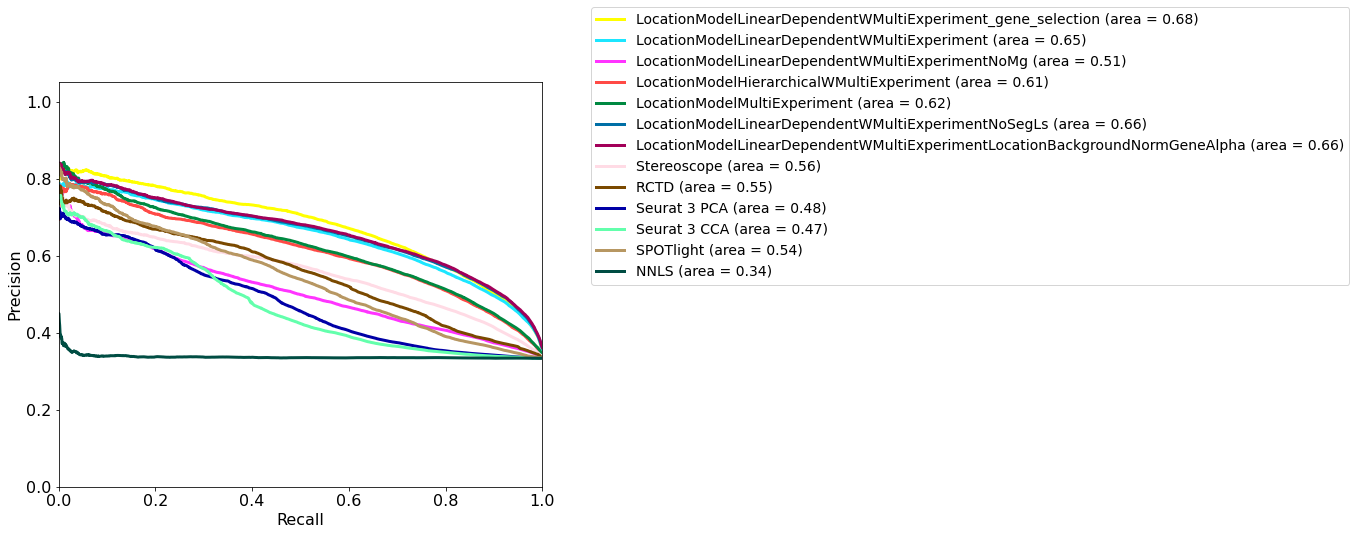

In [108]:
rcParams['figure.figsize'] = 20, 8
rcParams['font.size'] = 16
compare_precision_recall(pos_cell_count, results,
                         method_title=names, 
                         legend_loc=(1.1, 0.5))
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison_all.pdf')

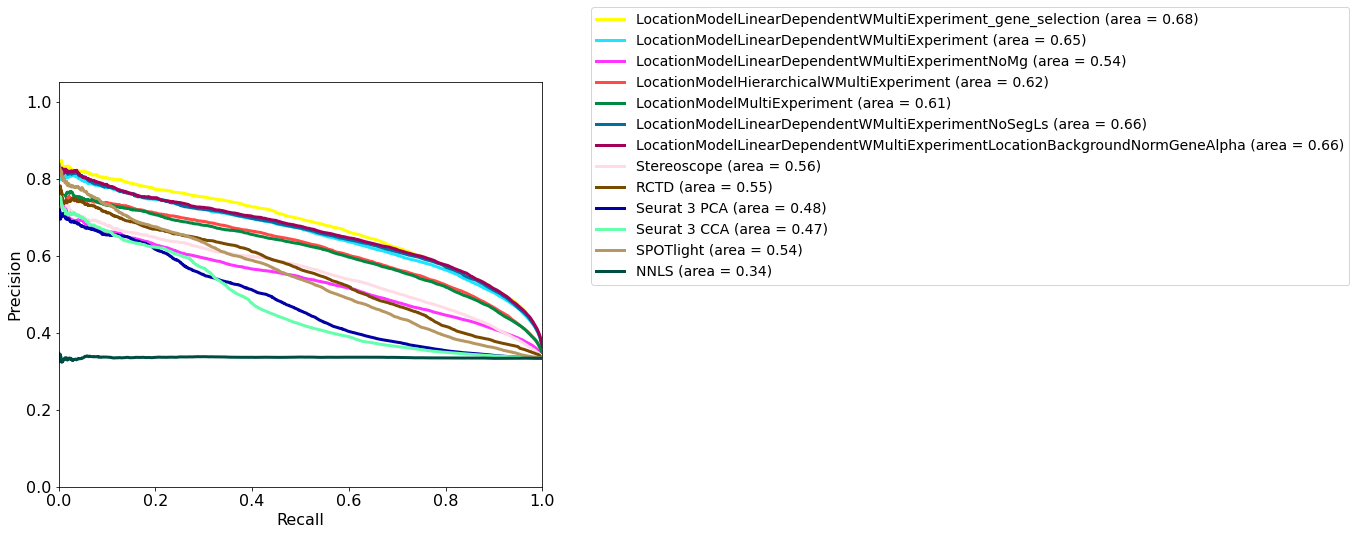

In [109]:
rcParams['figure.figsize'] = 20, 8
rcParams['font.size'] = 16
compare_precision_recall(pos_cell_count, results_count,
                         method_title=names, 
                         legend_loc=(1.1, 0.5))
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison_all_count.pdf')

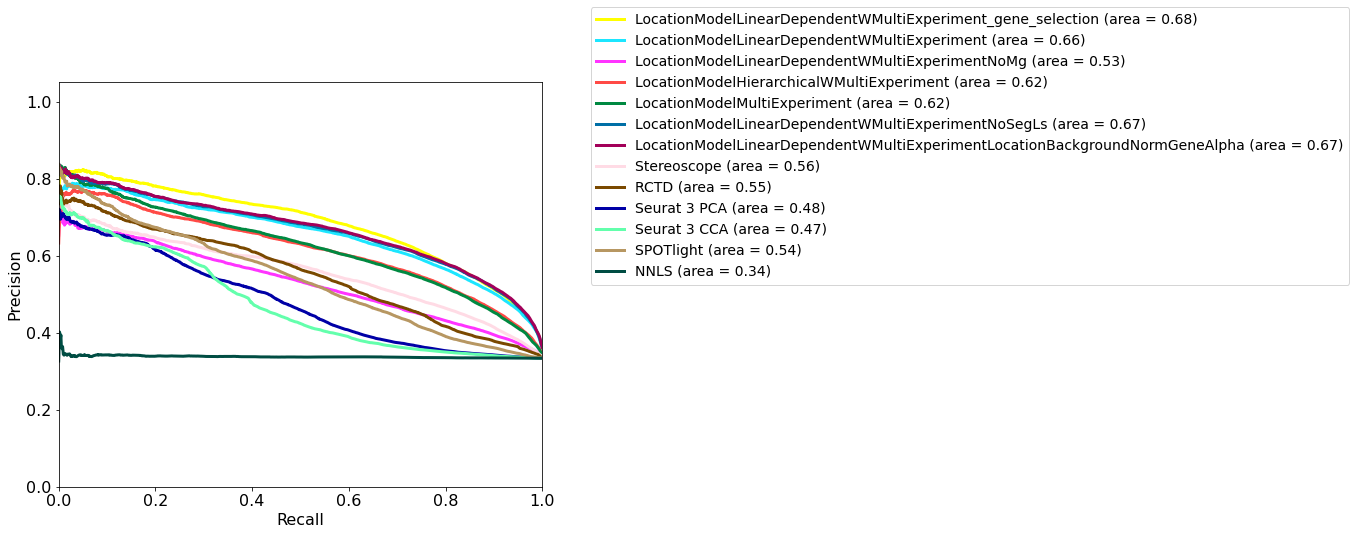

In [110]:
rcParams['figure.figsize'] = 20, 8
rcParams['font.size'] = 16
compare_precision_recall(pos_cell_count, results_q05,
                         method_title=names, 
                         legend_loc=(1.1, 0.5))
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison_q05_all.pdf')

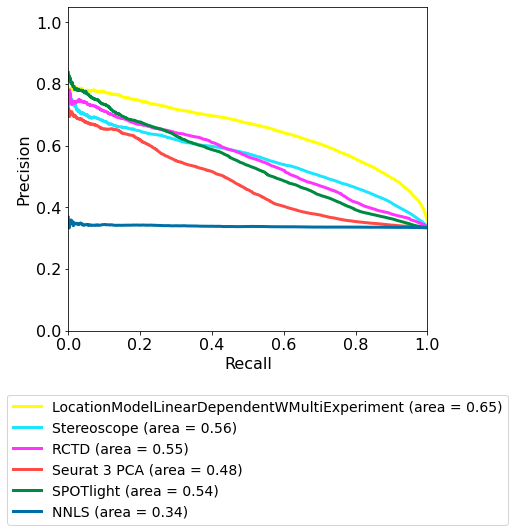

In [111]:
rcParams['figure.figsize'] = 7,8
rcParams['font.size'] = 16

mod_names = ['LocationModelLinearDependentWMultiExperiment',
             'Stereoscope',
             'RCTD',
             'Seurat 3 PCA',
             'SPOTlight',
             'NNLS'
            ]

results_dict = {}
for i, n in enumerate(names):
    results_dict[n] = results[i]

results_dict_sel = {}
for i, n in enumerate(mod_names):
    results_dict_sel[n] = results_dict[n]

compare_precision_recall(pos_cell_count, list(results_dict_sel.values()),
                         method_title=list(results_dict_sel.keys()),
                         legend_loc=(-0.17, -0.6))
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison_selected_FigS2.pdf')

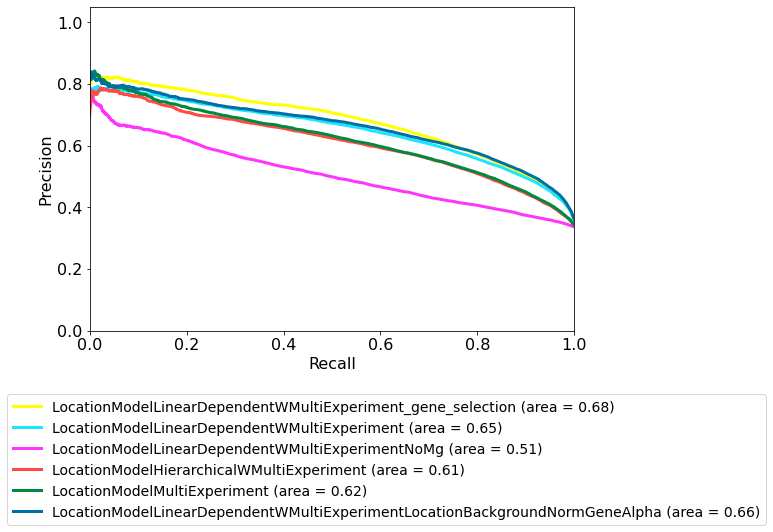

In [113]:
rcParams['figure.figsize'] = 10,8
rcParams['font.size'] = 16

mod_names = ['LocationModelLinearDependentWMultiExperiment_gene_selection',
             'LocationModelLinearDependentWMultiExperiment',
 'LocationModelLinearDependentWMultiExperimentNoMg',
 'LocationModelHierarchicalWMultiExperiment',
 'LocationModelMultiExperiment',
 'LocationModelLinearDependentWMultiExperimentLocationBackgroundNormGeneAlpha'
            ]

results_dict = {}
for i, n in enumerate(names):
    results_dict[n] = results[i]

results_dict_sel = {}
for i, n in enumerate(mod_names):
    results_dict_sel[n] = results_dict[n]

if False:
    compare_precision_recall(pos_cell_count, list(results_dict_sel.values()),
                             method_title=list(results_dict_sel.keys()),
                             legend_loc=(-0.17, -0.6), curve='ROC')
    plt.tight_layout()
    plt.savefig(fig_path + '/ROC_comparison_simplified_FigS2.pdf')
    plt.show()

compare_precision_recall(pos_cell_count, list(results_dict_sel.values()),
                         method_title=list(results_dict_sel.keys()),
                         legend_loc=(-0.17, -0.6), curve='PR')
plt.tight_layout()
plt.savefig(fig_path + '/PR_comparison_simplified_FigS2.pdf')
plt.show()

#### Compares using RMSE on proportions

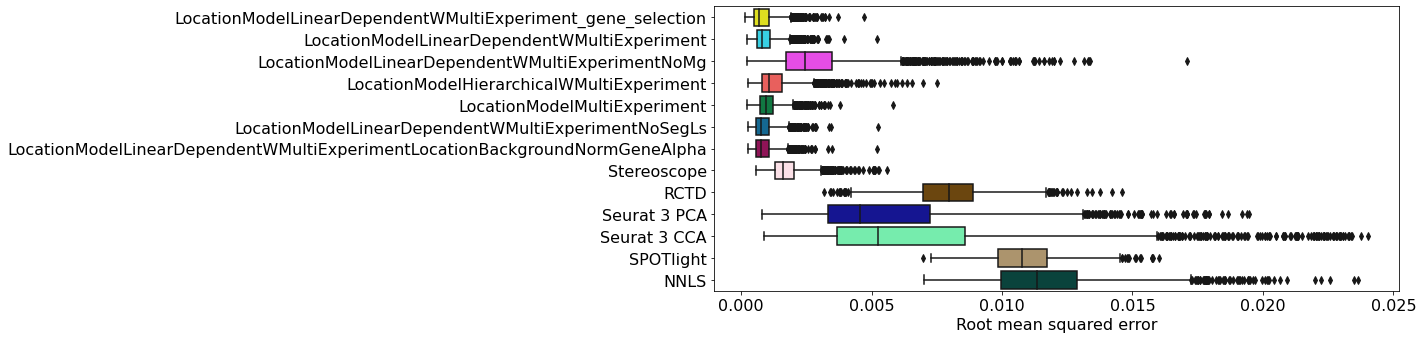

In [114]:
from sklearn.metrics import mean_squared_error
rmse = pd.DataFrame()
for i in range(len(results)):
    rmse[names[i]] = ((cell_proportions - results[i]) ** 2).mean(1)

rcParams['figure.figsize'] = 20, 5
sns.boxplot(data=rmse, orient="h", palette=sc.pl.palettes.default_102).set(
    xlabel='Root mean squared error'
)
plt.tight_layout()
plt.savefig(fig_path + '/RMSE_comparison_all.pdf')
plt.show()

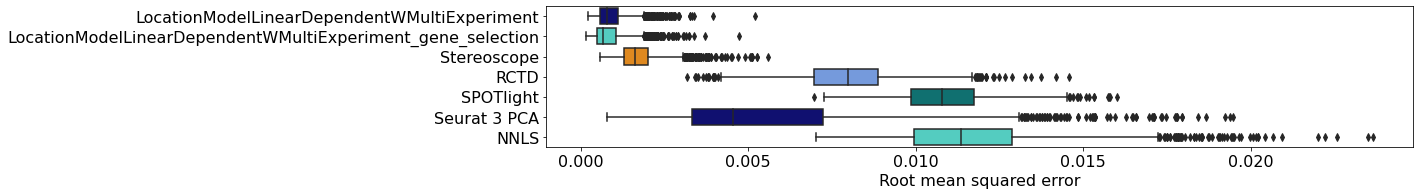

In [116]:
rcParams['figure.figsize'] = 20, 3
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 16

mod_names = ['LocationModelLinearDependentWMultiExperiment',
             'LocationModelLinearDependentWMultiExperiment_gene_selection',
             'Stereoscope',
             'RCTD',
             'SPOTlight',
             'Seurat 3 PCA',
             'NNLS']

from itertools import cycle
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
my_palette = dict(zip(mod_names, colors))

sns.boxplot(data=rmse[mod_names], orient="h", palette=my_palette).set(
    xlabel='Root mean squared error'
)
plt.tight_layout()
plt.savefig(fig_path + '/RMSE_comparison_selected.pdf')
plt.show()

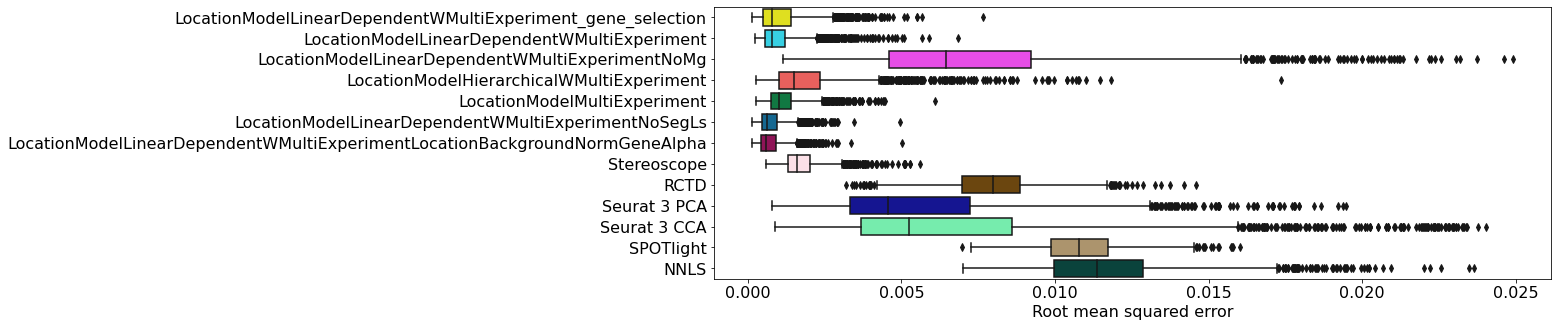

In [117]:
rmse_q05 = pd.DataFrame()
for i in range(len(results)):
    rmse_q05[names[i]] = ((cell_proportions - results_q05[i]) ** 2).mean(1)
    
rcParams['figure.figsize'] = 15, 5
sns.boxplot(data=rmse_q05, orient="h", palette=sc.pl.palettes.default_102).set(
    xlabel='Root mean squared error'
)
plt.show()